# Аналитика продукта, продаж и маркетинга Яндекс.Афиши <a id="начало"></a>

## Описание проекта <a id="описание"></a>

**Заказчик:** Яндекс.Афиша — онлайн-сервис по продаже билетов на развлекательные мероприятия

**Что исследуем:** посещаемость сайта, покупательское поведение и окупаемость маркетинга

**Цель:** оптимизировать маркетинговые затраты

**Задачи**:
+ описать, как люди пользуются продуктом
+ определить, когда они начинают покупать
+ посчитать, сколько денег приносит каждый клиент
+ установить, когда клиент окупается
+ сформулировать рекомендации, куда и сколько (источники/платформы) маркетологам стоит вкладывать денег 

**С какими данными работаем:** Данные с сайта сервиса за период с июня 2017 по конец мая 2018 года
+ данные о посещении сайта
+ выгрузка всех заказов
+ статистика рекламных расходов

**Вопросы заказчика:** <br>
<br>
**Про продукт** <br>
+ Сколько людей пользуются в день, неделю, месяц?
+ Сколько сессий в день?
+ Сколько длится одна сессия?
+ Как часто люди возвращаются?

**Про продажи** <br>
+ Когда люди начинают покупать?
+ Сколько раз покупают за период?
+ Какой средний чек?
+ Сколько денег приносят? (LTV)

**Про маркетинг** <br>
+ Сколько денег потратили? Всего / на каждый источник / по времени
+ Сколько стоило привлечение одного покупателя из каждого источника?
+ На сколько окупились расходы? (ROI)

Как все эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

## Шаг 1. Изучение и предобработка данных <a id="Шаг_1"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion1)

Подготовим таблицы к анализу. <br>
Создадим дополнительные таблицы для когортного анализа и анализа в разрезе устройств и источников трафика.

### Описание таблиц

In [2]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import warnings # возникали предупреждения, но код работал
warnings.filterwarnings('ignore') # решил отключить эти предупреждения

pd.options.display.float_format = '{: .2f}'.format

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')


plt.style.use('seaborn') 
sns.set(style="darkgrid")

**Таблица visits (информация о визитах; 5 столбцов):**
1. Uid — уникальный идентификатор пользователя
2. Device — категория устройства пользователя
3. Start Ts — дата и время начала сессии
4. End Ts — дата и время окончания сессии
5. Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [3]:
# изучаем данные
visits.info()
print('кол-во строк-дубликатов: ', visits.duplicated().sum())
display(visits.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
кол-во строк-дубликатов:  0


,Device,End Ts,Source Id,Start Ts,Uid
10663,desktop,2017-09-04 10:27:00,4,2017-09-04 10:26:00,7077232557926507517
166612,desktop,2017-09-16 12:52:00,5,2017-09-16 12:27:00,17702754228260152570
91428,desktop,2018-01-16 18:51:00,3,2018-01-16 18:33:00,16400599590759893587
59158,touch,2017-10-14 11:05:00,4,2017-10-14 11:03:00,16871869455843324296
235015,touch,2017-11-21 17:42:00,4,2017-11-21 17:06:00,5483861566648894131


В таблице visits нет пропусков и дубликатов. <br>
Столбцы с датой следует привести к нужному типу — datetime <br>
Названия столбцов стоит привести к написанию в нижнем регистре и заменить на более понятные для удобства.

**Таблица orders (информация о визитах; 3 столбца):**
1. Uid — уникальный id пользователя, который сделал заказ
2. Buy Ts — дата и время заказа
3. Revenue — выручка Яндекс.Афиши с этого заказа

In [4]:
# изучаем данные
orders.info()
print('кол-во строк-дубликатов: ', orders.duplicated().sum())
display(orders.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
кол-во строк-дубликатов:  0


,Buy Ts,Revenue,Uid
10781,2017-10-05 12:02:00,1.10,11730693852878275789
43800,2018-04-11 17:05:00,1.71,3172646080215736180
23586,2017-12-12 14:37:00,4.58,8386764976495437347
26236,2017-12-26 17:10:00,1.11,18376238448677056681
28456,2018-01-07 20:38:00,0.64,6027978920176608735


В таблице orders нет пропусков и дубликатов. <br>
Столбец с датой следует привести к нужному типу — datetime <br>
Названия столбцов стоит привести к написанию в нижнем регистре для удобства.

**Таблица costs (информация о визитах; 3 столбца):**
1. source_id — идентификатор рекламного источника (является внешним ключом к таблице visits и указывает на тип источника)
2. dt — дата
3. costs — затраты на этот рекламный источник в этот день

In [5]:
# изучаем данные
costs.info()
print('кол-во строк-дубликатов: ', costs.duplicated().sum())
display(costs.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
кол-во строк-дубликатов:  0


,source_id,dt,costs
2326,10,2017-10-26,1.71
32,1,2017-07-03,21.56
2370,10,2017-12-09,20.90
1050,3,2018-04-23,396.01
2305,10,2017-10-05,10.26


В таблице costs нет пропусков. <br>
Столбец с датой следует привести к нужному типу datetime и заменить название для удобства. <br>

### Замена типов данных и переименование столбцов

[к оглавлению](#оглавление)

In [6]:
# обработаем столбцы в таблице visits

#переименуем столбцы
visits = visits.rename(columns = {'Start Ts': 'start_session_time',
                                  'End Ts': 'end_session_time',
                                  'Source Id': 'source_id'})

# заменим тип данных
visits['start_session_time'] = pd.to_datetime(visits['start_session_time'])
visits['end_session_time'] = pd.to_datetime(visits['end_session_time'])

# приведем написание названий столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device                359400 non-null object
end_session_time      359400 non-null datetime64[ns]
source_id             359400 non-null int64
start_session_time    359400 non-null datetime64[ns]
uid                   359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
# обработаем столбцы в таблице orders

#переименуем столбцы
orders = orders.rename(columns = {'Buy Ts': 'order_time'})

# заменим тип данных
orders['order_time'] = pd.to_datetime(orders['order_time'])

# приведем написание названий столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_time    50415 non-null datetime64[ns]
revenue       50415 non-null float64
uid           50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [8]:
# обработаем столбец с датой в таблице costs

#переименуем столбец
costs = costs.rename(columns = {'dt': 'acquisition_day'})

# заменим тип данных
costs['acquisition_day'] = pd.to_datetime(costs['acquisition_day'])

#создадим столбец с месяцем расходов (пригодится позже)
costs['month'] = costs['acquisition_day'].astype('datetime64[M]')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id          2542 non-null int64
acquisition_day    2542 non-null datetime64[ns]
costs              2542 non-null float64
month              2542 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 79.6 KB


### Подготовка данных для расчета метрик
[к оглавлению](#оглавление)

Чтобы дальше посчитать метрики нам нужно дополнить таблицы visits и orders и создать несколько новых таблиц.<br>

#### Обновим таблицу visits

Добавим к таблице информацию о месяце, неделе и дне каждого визита. <br>
Добавим столбец с продолжительностью сессий. <br>
Добавим столбец с датой и месяцем первого визита. <br>
Рассчитаем возраст каждого пользователя на каждый визит.

Это нужно для:
1. Retention анализа
2. Анализа продолжительности сессий

In [9]:
# получим столбцы с месяцем, неделей и днем визита с помощью типа данных datetime64[X]

# сразу же приведем значени полученных столбцов к формату даты с помощью dt.date -- так они будут лучше отражаться на графиках

visits['month']  = pd.to_datetime(visits.start_session_time.astype('datetime64[M]'))
visits['day']  = pd.to_datetime(visits.start_session_time.astype('datetime64[D]'))
visits['week'] = (pd.to_datetime(visits.day, unit='d')
                           - pd.to_timedelta(visits.day.dt.dayofweek, unit='d'))

visits['day'] = visits['day'].dt.date

# создадим столбец с продолжительностью каждой сессии: вычтем из окончание сессии её начало и сохраним разницу в секундах
visits['duration'] = (visits['end_session_time'] - visits['start_session_time']).dt.total_seconds().astype('int')

visits.sample(10)

,device,end_session_time,source_id,start_session_time,uid,month,day,week,duration
38914,touch,2018-01-18 22:49:00,4,2018-01-18 22:31:00,7279333618056110411,2018-01-01,2018-01-18,2018-01-15,1080
346008,touch,2017-10-01 15:00:00,3,2017-10-01 15:00:00,17411671411137654067,2017-10-01,2017-10-01,2017-09-25,0
158278,touch,2018-05-31 05:33:00,3,2018-05-31 05:32:00,1734217560519927647,2018-05-01,2018-05-31,2018-05-28,60
272841,touch,2017-10-24 18:17:00,5,2017-10-24 18:17:00,18236571758967838125,2017-10-01,2017-10-24,2017-10-23,0
43029,touch,2018-03-28 01:19:00,4,2018-03-28 01:14:00,15098557910634688279,2018-03-01,2018-03-28,2018-03-26,300
275418,desktop,2018-01-14 08:08:00,3,2018-01-14 08:08:00,4377934741234616132,2018-01-01,2018-01-14,2018-01-08,0
43756,desktop,2017-12-29 14:16:00,5,2017-12-29 14:11:00,11949476875081714558,2017-12-01,2017-12-29,2017-12-25,300
208867,desktop,2017-10-13 23:55:00,4,2017-10-13 23:30:00,1277984644036797912,2017-10-01,2017-10-13,2017-10-09,1500
266977,desktop,2018-03-03 11:55:00,5,2018-03-03 11:49:00,11089245571446134593,2018-03-01,2018-03-03,2018-02-26,360
35514,desktop,2018-03-28 13:03:00,5,2018-03-28 12:59:00,16083859506449328,2018-03-01,2018-03-28,2018-03-26,240


In [10]:
# найдем дату первого визита для каждого пользователя
first_visit_date = visits.groupby(['uid'])['day'].min()
first_visit_date.name = 'first_visit_date'

# добавим эту дату к датафрейму visits
visits = visits.merge(first_visit_date, on = 'uid')


### на этом месте почему-то сильно зависает =((((((

In [11]:
# найдем месяц первого визита, чтобы построить месячный retention отчет
visits['first_visit_month']  = pd.to_datetime(visits['first_visit_date'].astype('datetime64[M]'))

In [12]:
# посчитаем время жизни когорты в месяцах
visits['lifetime_month'] = visits['month'] - visits['first_visit_month']
visits['lifetime_month'] = visits['lifetime_month'] / np.timedelta64(1,'M')
visits['lifetime_month'] = visits['lifetime_month'].round().astype('int')

# приведем даты к более читаемому виду (для графиков)
visits['first_visit_month'] = visits['first_visit_month'].dt.date
visits['month'] = visits['month'].dt.date

visits.sample(5)

,device,end_session_time,source_id,start_session_time,uid,month,day,week,duration,first_visit_date,first_visit_month,lifetime_month
156849,touch,2017-09-16 09:18:00,4,2017-09-16 09:11:00,15540221816531237258,2017-09-01,2017-09-16,2017-09-11,420,2017-09-16,2017-09-01,0
157839,touch,2017-11-03 23:11:00,2,2017-11-03 23:10:00,980287827642878233,2017-11-01,2017-11-03,2017-10-30,60,2017-11-03,2017-11-01,0
8951,desktop,2018-02-15 11:05:00,2,2018-02-15 10:06:00,11920452646463905188,2018-02-01,2018-02-15,2018-02-12,3540,2017-06-01,2017-06-01,8
264162,desktop,2017-10-10 19:11:00,4,2017-10-10 19:06:00,3737351382327864570,2017-10-01,2017-10-10,2017-10-09,300,2017-10-10,2017-10-01,0
50872,desktop,2018-02-15 22:12:00,10,2018-02-15 22:03:00,15361880775196083572,2018-02-01,2018-02-15,2018-02-12,540,2018-02-15,2018-02-01,0


Мы получили новый столбец с числовыми значениями duration. <br>
Стоит проверить, есть ли в нем неадкватные значения.

In [13]:
# проверим столбец с продолжительностью сессий
visits['duration'].describe()

count    359400.00
mean        643.03
std         997.13
min       -2760.00
25%         120.00
50%         300.00
75%         840.00
max       42660.00
Name: duration, dtype: float64

В таблице есть очень экстримальные значения: отрицательное время и слишком большое время. <br>
Изучим их подробнее.

In [14]:
# изучим, что это за сессиии
visits.query('duration < 0 or duration == duration.max()')

,device,end_session_time,source_id,start_session_time,uid,month,day,week,duration,first_visit_date,first_visit_month,lifetime_month
27980,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-01,2018-03-25,2018-03-19,-1920,2017-11-12,2017-11-01,4
59662,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-01,2018-03-25,2018-03-19,-2760,2018-03-19,2018-03-01,0
286202,desktop,2017-12-18 22:43:00,3,2017-12-18 10:52:00,15566184277200431914,2017-12-01,2017-12-18,2017-12-18,42660,2017-12-18,2017-12-01,0


Оказывается, в датасе есть сессии длинной около 12 часов, а также сессии с отрицательными значениями. <br>

Условимся, что сессии дольше 1 часа указывают на случаи, когда пользователь надолго оставил вкладку открытойи не пользоваля сайтом. <br>

Сессии меньше 0 секунд будем считать ошибкой.

Датасет не будет очищать от таких сессий, чтобы не возникло никаких ошибок при совмещении таблицы visits и orders в дальнейшем.

In [15]:
# создадим баг-репорт про неправильные логи (строки таблицы visits, в которых время начала сессии позже, чем её окончание)
visists_broken_logs = visits.query('duration < 0')

# типа что сохраняем баг-репорт в отдельный файл
# visists_broken_logs_file = visists_broken_logs.to_csv('orders_broken_logs')

#### Создадим талицу с информацией о визитах пользователей
Добавим информацию о времени, дне и месяце первого визита, а также источник первого визита и устройство.

In [16]:
# получим данные о первом визите каждого пользователя
users_info = (visits
                     .sort_values(by = ['uid', 'start_session_time']) # сортируем таблицу по возрастанию id и времени первой сессии
                     .groupby('uid')
                     .agg(
                         {
                             'start_session_time' : 'first', # дата и время первой сессии
                             'source_id': 'first', # источник первой сессии - он же источник привлечения пользователя
                             'device': 'first'} # тип устройства, с которого совершена первая сессия
                         ).reset_index()
                )

# обновим название столбцов в отчете о первом визите пользователя, который построили раньше
users_info = users_info.rename(columns = {'start_session_time': 'first_visit_time'})

#создадим столбец с месяцем первого визита
users_info['acquisition_month'] = users_info['first_visit_time'].astype('datetime64[M]').dt.date

# создадим столбец с днем первого визита - он же день привлечения пользователя
users_info['acquisition_day'] = users_info['first_visit_time'].dt.date

users_info.head()

,uid,first_visit_time,source_id,device,acquisition_month,acquisition_day
0,11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2,touch,2018-02-01,2018-02-06
2,297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-01,2017-06-07
3,313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-01,2017-09-18
4,325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-01,2017-09-30


In [17]:
users_info = (users_info
                  .reset_index()
                  # сгруппируем полученную таблицу по id источника трафика и месяцу привлечения
                  .set_index(['source_id', 'acquisition_day']) 
                  # соеденим таблицу с таблицей расходов по источнику и дню привлечения / расхода маркетиногвого бюджета
                  .join(costs.set_index(['source_id', 'acquisition_day']), how = 'left')
             )


users_info = users_info.reset_index().set_index('uid')[['first_visit_time', 'acquisition_day', 'acquisition_month', 'source_id', 'device']]
users_info = users_info.reset_index()
users_info.head()

,uid,first_visit_time,acquisition_day,acquisition_month,source_id,device
0,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop
1,618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch
2,1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop
3,1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop
4,1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop


***

#### Создадим отчет по покупателям (пользователи, которые купили)

Этот отчет будет постороен только по тем, посетителям сайта, которые совершили покупку. <br>

Для каждого из них найдем:
1. время первого заказа
2. месяц первого заказа
3. день первого визита (день привлечения)
4. источник, по которому пользователь попал на сайт в первый раз
5. тип устройства, с которого пользователь первый раз перешел на сайт
6. стоимость привлечения

In [18]:
# группируем таблицу с заказами по пользователям я для каждого находим время первого заказа и сумммарную выручку
buyers_info = (orders
                     .groupby('uid')
                     .agg({'order_time' : 'min', 'revenue': 'sum'}) # тип устройства, с которого совершена первая сессия
                     .reset_index()
                )

buyers_info.head()

,uid,order_time,revenue
0,313578113262317,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,3.05
2,2429014661409475,2017-10-11 18:33:00,73.33
3,2464366381792757,2018-01-28 15:54:00,2.44
4,2551852515556206,2017-11-24 10:14:00,10.99


In [19]:
# добавим к полученной таблице информацию о дне и месяце привлечения, источнике привлечения и первом устройстве
buyers_info = buyers_info.merge(users_info[['uid', 'acquisition_day', 'acquisition_month', 'source_id', 'device']], how = 'left')

# переименуем столбцы
buyers_info = buyers_info.rename(columns = {'order_time': 'first_order_time'})

# найдем день первого заказа
buyers_info['first_order_day'] = pd.to_datetime(buyers_info['first_order_time'].astype('datetime64[D]'))

buyers_info.head()

,uid,first_order_time,revenue,acquisition_day,acquisition_month,source_id,device,first_order_day
0,313578113262317,2018-01-03 21:51:00,0.55,2017-09-18,2017-09-01,2,desktop,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03,2017-06-01,10,touch,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,73.33,2017-10-11,2017-10-01,3,desktop,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2.44,2018-01-27,2018-01-01,5,desktop,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,10.99,2017-11-24,2017-11-01,5,desktop,2017-11-24


In [20]:
# добавим данные о маркетинговых расходах на каждый день привлечения, чтобы позже посчитать стоимость привлечения клиента

buyers_info = (buyers_info
                  # сгруппируем полученную таблицу по источнику трафика и дню привлечения (дню первого визита)
                  .set_index(['source_id', 'acquisition_day']) 
                  # соеденим таблицу с таблицей расходов по источнику и дню привлечения
                  #(день расхода маркетиногвого бюджета в таблице costs)
                  .join(costs.set_index(['source_id', 'acquisition_day']), how = 'left')
             )


buyers_info.head()

uid    first_order_time  revenue  \
source_id acquisition_day                                                     
1         2017-06-01        469568501030474895 2017-09-11 00:06:00    70.69   
          2017-06-01       1074355127080856382 2017-06-01 09:23:00     0.37   
          2017-06-01       1292867924428534308 2017-06-01 16:47:00     4.28   
          2017-06-01       2050423809815667474 2017-06-01 10:38:00     8.31   
          2017-06-01       3520273333047097992 2017-06-01 20:35:00     0.24   

                          acquisition_month   device first_order_day  costs  \
source_id acquisition_day                                                     
1         2017-06-01             2017-06-01  desktop      2017-09-11  75.20   
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20   
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20   
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20   
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20   

                               month  
source_id acquisition_day             
1         2017-06-01      2017-06-01  
          2017-06-01      2017-06-01  
          2017-06-01      2017-06-01  
          2017-06-01      2017-06-01  
          2017-06-01      2017-06-01

In [21]:
# сделаем таблицу, в которой по каждому источнику трафика на каждый день отобразим
# кол-во привлеченных пользователей, которые сделали заказ
# маркетинговые расходы
# стоимость привлечения платещего пользователя

customer_cost = (buyers_info
                 .groupby(['source_id', 'acquisition_day']) # группируем: для каждого источника отобразим каждый день
                 .agg({'uid': 'nunique', 'costs': 'max'}) # считаем кол-во уникальных пользователей и определяем сумму расходов
                 .rename(columns = {'uid': 'buyers'})
            )
# далее считаем среднюю стоимость одного привлеченного пользователя
customer_cost['cac'] = customer_cost['costs'] / customer_cost['buyers']

customer_cost.head()

buyers  costs   cac
source_id acquisition_day                     
1         2017-06-01           24  75.20  3.13
          2017-06-02           12  62.25  5.19
          2017-06-03            8  36.53  4.57
          2017-06-04            6  55.00  9.17
          2017-06-05           20  57.08  2.85

In [22]:
# добавим стоимост ьпривлечения каждого клиента
buyers_info = buyers_info.join(customer_cost['cac'], how = 'left')

#сбросим индекс
buyers_info = buyers_info.reset_index()

# удалим ненужные столбцы
buyers_info = buyers_info.drop(columns=['first_order_time'])

buyers_info.head()

,source_id,acquisition_day,uid,revenue,acquisition_month,device,first_order_day,costs,month,cac
0,1,2017-06-01,469568501030474895,70.69,2017-06-01,desktop,2017-09-11,75.20,2017-06-01,3.13
1,1,2017-06-01,1074355127080856382,0.37,2017-06-01,desktop,2017-06-01,75.20,2017-06-01,3.13
2,1,2017-06-01,1292867924428534308,4.28,2017-06-01,desktop,2017-06-01,75.20,2017-06-01,3.13
3,1,2017-06-01,2050423809815667474,8.31,2017-06-01,desktop,2017-06-01,75.20,2017-06-01,3.13
4,1,2017-06-01,3520273333047097992,0.24,2017-06-01,desktop,2017-06-01,75.20,2017-06-01,3.13


#### Дополним таблицу orders

Добавим время и месяц первого заказа. <br>
Добавим столбец с месяцем каждого заказа. <br>
Добавим источник и устройство первого посещения сайта для каждого пользователя. <br>
Добавим дату привлечения каждого пользователя.

Все это будет нужно для:
1. Когортного анализа ROI и LTV
2. Анализа доходов

In [23]:
# создадим столбец с датой первого заказа в таблице с заказами

first_order_date_by_customers = orders.groupby('uid')['order_time'].min()
first_order_date_by_customers.name = 'first_order_time'
orders = orders.join(first_order_date_by_customers, on='uid')

# получим данные о первом заказе
first_orders = (orders
                        .sort_values(by = ['uid', 'order_time']) # сортируем таблицу заказов по убыванию даты заказов
                        .groupby('uid')                # для каждого пользователя
                        .agg({'order_time' : 'first'}) # нахожим дату первого заказа
               )
first_orders.head()

#создадим столбец с месяцем первого заказа
orders['first_order_month'] = orders['first_order_time'].astype('datetime64[M]').dt.date

#создадим столбец с месяцем каждого заказа
orders['order_month'] = orders['order_time'].astype('datetime64[M]').dt.date


# к каждому заказу пришьем
# источник трафика от первого визита пользователя
# и устройство первого визита
# месяц первого визита
# cтоимость привлечения
# это будет нужно для анализа продаж в разрезе устройств и источников трафика
orders = orders.merge(buyers_info[['uid', 'acquisition_month', 'source_id', 'device', 'cac']],  how='left', on = 'uid')


# добавим возраст каждого клиента на каждый месяц покупки
orders['cohort_age'] = (
                                (orders['order_month']
                                   - orders['acquisition_month'])
                                / np.timedelta64(1,'M')
                                )
orders['cohort_age'] = orders['cohort_age'].round().astype('int')


orders.head()

,order_time,revenue,uid,first_order_time,first_order_month,order_month,acquisition_month,source_id,device,cac,cohort_age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01,1,desktop,3.13,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01,3,desktop,7.60,0


***

#### Создадим таблицу для расчета времени до покупки

In [24]:
# получим данные о первом заказе
first_orders = (orders
                        .groupby('uid')                # для каждого пользователя
                        .agg({'order_time' : 'min'}) # нахожим дату первого заказа
               )
first_orders.head()

,order_time
uid,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00
2464366381792757,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00


In [25]:
# создаим отчет о первых визитах и покупках каждого пользователя

# к отчету о первом визите каждого пользователя добавим дату его первого заказа и переименуем столбцы
time_report = users_info.merge(first_orders, on = 'uid')
time_report = time_report.rename(columns = {'start_session_time': 'first_visit_time',
                                  'order_time': 'first_order_time',
                                  })



# создадим столбцы с днями первого визита и первого заказа
# а также с количеством дней и минут между первым визитом и покупкой

time_report['first_visit_day'] = time_report['first_visit_time'].astype('datetime64[D]').dt.date
time_report['first_order_day'] = time_report['first_order_time'].astype('datetime64[D]').dt.date
time_report['days_bf_order'] = (time_report['first_order_day'] - time_report['first_visit_day']).dt.days
time_report['minutes_bf_order'] = (time_report['first_order_time'] - time_report['first_visit_time']).dt.total_seconds() / 60

#дропнем лишние столбцы
time_report = time_report.drop(columns=['first_visit_time', 'source_id', 'acquisition_month', 'acquisition_day', 'first_order_time'])

time_report.head()

,uid,device,first_visit_day,first_order_day,days_bf_order,minutes_bf_order
0,469568501030474895,desktop,2017-06-01,2017-09-11,102,146556.00
1,1074355127080856382,desktop,2017-06-01,2017-06-01,0,2.00
2,1292867924428534308,desktop,2017-06-01,2017-06-01,0,234.00
3,2050423809815667474,desktop,2017-06-01,2017-06-01,0,2.00
4,3520273333047097992,desktop,2017-06-01,2017-06-01,0,27.00


In [26]:
# проверим полученные значения времени на адекватность
time_report[['days_bf_order', 'minutes_bf_order']].describe()

,days_bf_order,minutes_bf_order
count,36523.00,36523.00
mean,16.90,24340.18
std,47.07,67784.77
min,0.00,0.00
25%,0.00,4.00
50%,0.00,16.00
75%,2.00,2897.00
max,363.00,523144.00


В датасете встречаются случаи, где первый заказ случился раньше, чем первый визит.

Очистим датасет от таких строк.

In [27]:
# обновим репорт: исключим записи, где кол-во дней и минут до заказа меньше нуля
time_report = time_report.query('days_bf_order >= 0 and minutes_bf_order >=0')

# посмотрим, как изменились значения
time_report[['days_bf_order', 'minutes_bf_order']].describe()

,days_bf_order,minutes_bf_order
count,36523.00,36523.00
mean,16.90,24340.18
std,47.07,67784.77
min,0.00,0.00
25%,0.00,4.00
50%,0.00,16.00
75%,2.00,2897.00
max,363.00,523144.00


Теперь в таблице нет отрицательных значений и её можно использовать для отчета по времени до покупки.

***

#### Итоги предобработки данных
[К оглавлению](#оглавление)<br>

Во всех трех таблицах привели названия столбцов к более удобным и понятным. <br>
Столбы с датами привели к типу datetime.

Создали две дополнительные таблицы:
1. time_report — для анализа времени до первой покупки
2. buyers_info, где для каждого посетителя указали стоимость привлечения, канал привлечение и устройство первого визита

В таблице visits создали столбец duration для анализа продолжительности сессий.

В таблице orders создали столбцы с датой первого заказа и месяцем для каждого заказа, а также добавили всю информацию по каждому клиенту из buyers_info.

***

## Шаг 2. Расчет метрик <a id="Шаг_2"></a>
[К оглавлению](#оглавление)<br>

### Продуктовые метрики

**Чек-лист:**
- [x] Сколько людей пользуются в день, неделю, месяц?
- [x] Сколько сессий в день?
- [x] Сколько длится одна сессия?
- [x] Как часто люди возвращаются?
- [x] Отображено на графиках, как метрики отличаются по устройствам
- [x] Отображено на графиках, как метрики отличаются рекламным источникам
- [x] Отображено на графиках, как метрики меняются во времени

#### DAU, WAU и MAU <a id="howmuch"></a>

In [28]:
#считаем метрики пользовательской активности

# считаем, сколько пользователей в среднем за день заходят Яндекс.Афишу
dau_total = visits.groupby(['day']).agg({'uid': 'nunique'})

# считаем, сколько пользователей в среднем за неделю заходят Яндекс.Афишу
wau_total = visits.groupby(['week']).agg({'uid': 'nunique'})

# считаем, сколько пользователей в среднем за месяц заходят Яндекс.Афишу
mau_total = visits.groupby(['month']).agg({'uid': 'nunique'})

print("\n" + 'Уникальных пользователей в день:', int(dau_total.mean()), 'человек' + "\n")
print("\n" + 'Уникальных пользователей в неделю:', int(wau_total.mean()), 'человек' + "\n")
print("\n" + 'Уникальных пользователей в месяц:', int(mau_total.mean()), 'человек' + "\n")


Уникальных пользователей в день: 907 человек


Уникальных пользователей в неделю: 5716 человек


Уникальных пользователей в месяц: 23228 человек



#### Среднее количество сессий в день на сайте

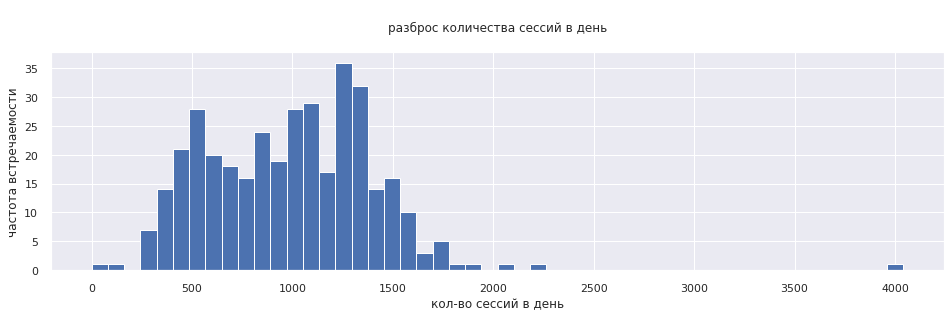


Среднее кол-во сессий в день на сайте Яндекс.Афиши: 987 



In [29]:
visits.groupby('day').agg({'uid': 'count'}).uid.hist(bins = 50, figsize = (16,4))
plt.xlabel('кол-во сессий в день')
plt.ylabel('частота встречаемости')
plt.title("\n" + 'разброс количества сессий в день' + "\n")
plt.show()
print("\n" + 'Среднее кол-во сессий в день на сайте Яндекс.Афиши:',
      int(visits.groupby('day').agg({'uid': 'count'}).uid.mean()), "\n")

#### Cредняя продолжительность сессии

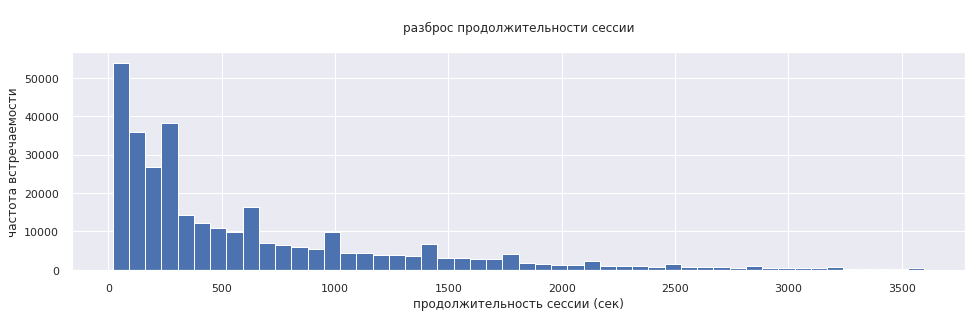


Средняя продолжительность сессии: 618 cекунд или 10 минут


Типичная (самая частая) продолжительность сессии: 60 cекунд



In [30]:
visits.query('duration > 0 and duration <= 3600').duration.hist(bins = 50, figsize = (16,4))
plt.xlabel('продолжительность сессии (сек)')
plt.ylabel('частота встречаемости')
plt.title("\n" + 'разброс продолжительности сессии' + "\n")
plt.show()

print("\n" + 'Средняя продолжительность сессии:',
      int(visits.query('duration > 0 and duration <= 3600').duration.mean()),
      'cекунд или', int(visits.query('duration > 0 and duration <= 3600').duration.mean()/60), 'минут'  + "\n")

print("\n" + 'Типичная (самая частая) продолжительность сессии:',
      int(visits.query('duration > 0 and duration <= 3600').duration.mode()), 'cекунд' + "\n")

В среднем за один месяц Яндекс.Афишу посещают 23 тысячи активных пользователей. <br>
В среднем за неделю — 5,7 тысяч. <br>
В день — 907. <br>

В среднем за день на сайте бывает 987 сессий продолжительности около 10 минут. <br>

Чаще всего на сайте проводят около 1 минуты.
1 минута на то, чтобы найти мероприятие и купить билеты — это очень быстро. Вероятно такое время сложилось из-за пользователей, которые заходят "только посмотерть", либо из пользователей, которые знают, зачем приходят, и быстро покупают билеты (например, в повторное посещение).

#### Как часто возвращаются пользователи? Retention Rate и Sticky Factor

Узнаем, сколько в среднем сессий приходится на одного пользователя в месяц, чтобы узнать, как часто возвращаются пользователи.

In [31]:
# сначала сгруппируем данные по году и месяцу и посчитаем кол-во уникальных пользователей и их визитов
sessions_per_user = visits.groupby(['month']).agg({'uid': ['count','nunique']}).reset_index()
sessions_per_user.columns = ['month', 'n_sessions', 'n_users']

# посчитаем среднее кол-во сессий на пользователя за каждый месяц
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
display(sessions_per_user.head(20))

# посчитаем среднее кол-во сессий на пользователя в месяц
print('\n' + 'Среднее кол-во сессий на одного пользователя в месяц:',
          round(sessions_per_user.n_sessions.sum() / sessions_per_user.n_users.sum(), 1)) 

,month,n_sessions,n_users,sess_per_user
0,2017-06-01,16505,13259,1.24
1,2017-07-01,17828,14183,1.26
2,2017-08-01,14355,11631,1.23
3,2017-09-01,23907,18975,1.26
4,2017-10-01,37903,29692,1.28
5,2017-11-01,43969,32797,1.34
6,2017-12-01,41983,31557,1.33
7,2018-01-01,36939,28716,1.29
8,2018-02-01,37182,28749,1.29
9,2018-03-01,35679,27473,1.30



Среднее кол-во сессий на одного пользователя в месяц: 1.3


In [32]:
# изучим также месячный sticky factor Яндекс.Афиши

sticky_mau = dau_total.mean() / mau_total.mean() * 100
sticky_mau
print('\n', round(sticky_mau[0], 1), '— доля уникальных пользователей, которые повторно зашли на сайт в течение месяца')


 3.9 — доля уникальных пользователей, которые повторно зашли на сайт в течение месяца


После первого визита повторно на сайт в течение месяца заходят только 4% от всех месячных посетителей. <br>
Это низкий Sticky Factor, а значит пользователи заходят на сайт Яндекс.Афиши не регулярно.


Средний пользователь проводит в приложении максимум 1 сессию. <br>
Это значит, что после своей первой сессии в конкретный месяц пользователи редко возвращаются на сайт в течение этого же месяца.

Однако для сервиса-афиши такие показатели кажутся адекватными: далеко не все люди посещают концерты и прочие мероприятия каждую неделю.

Далее изучим Retention rate для сайта.

У нас есть таблица visits, которую мы подготовили для когортного анализа Retention rate. <br>
Воспользуемся ей.

In [33]:
#Сгруппируем данные по когорте и lifetime.
#Посчитаем для каждой когорты количество активных пользователей на определённый период жизни
month_visits_cohorts = visits.groupby(['first_visit_month','lifetime_month']).agg({'uid':'nunique'}).reset_index() 
month_visits_cohorts.head()

,first_visit_month,lifetime_month,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц. <br> 

Найдём исходное количество пользователей в когортах. Возьмём их число на нулевой месяц.

In [34]:
# найдем кол-во пользоваетелей на каждый нулевой месяц возраста когорты:
# отберем из таблицы с когортами только те строки, где месяц нулевой

month_cohort_size = month_visits_cohorts[month_visits_cohorts['lifetime_month'] == 0][['first_visit_month','uid']]
month_cohort_size = month_cohort_size.rename(columns={'uid':'cohort_users'})
month_cohort_size = month_cohort_size.reset_index().drop(columns = 'index')
month_cohort_size

,first_visit_month,cohort_users
0,2017-06-01,13259
1,2017-07-01,13140
2,2017-08-01,10181
3,2017-09-01,16704
4,2017-10-01,25977
5,2017-11-01,27248
6,2017-12-01,25268
7,2018-01-01,22624
8,2018-02-01,22197
9,2018-03-01,20589


In [35]:
# к таблице с когортам добавим информацию о размере когорты в месяц привлечения
month_visits_cohorts = month_visits_cohorts.merge(month_cohort_size,on='first_visit_month')

# посчитаем retention как отношение кол-ва пользователей в каждый следующий месяц к количеству пользователей в первый месяц
month_visits_cohorts['retention'] = month_visits_cohorts['uid'] / month_visits_cohorts['cohort_users'] 
month_visits_cohorts.head()

,first_visit_month,lifetime_month,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07


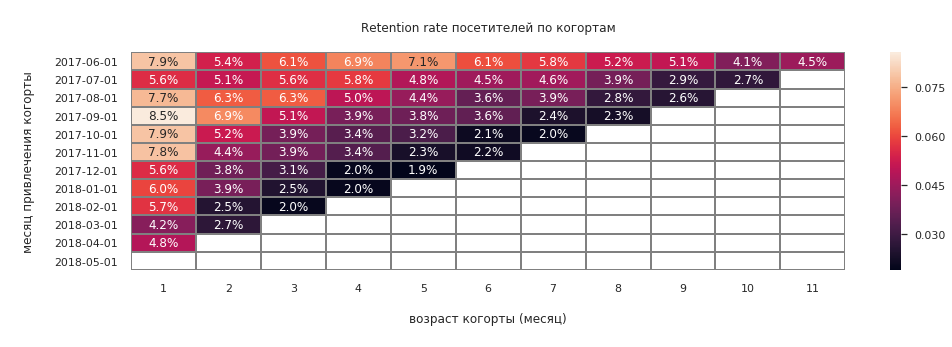

lifetime_month,1,2,3,4,5,6,7,8,9,10,11
средний retention,0.07,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.04


In [36]:
# сделаем сводную таблицу:
# для каждой когорты на каждый месяц жизни отобразим долю вернувшихся пользователей от их изначального кол-ва

retention_pivot = (month_visits_cohorts
                   .pivot_table(index='first_visit_month',
                                      columns='lifetime_month',
                                      values='retention',
                                      aggfunc='sum')
                  )

# удалим нулевой возраст, потому что в нем удержание будет 100%
retention_pivot = retention_pivot.drop(columns = 0)

# визуализируем таблицу
sns.set(style='white')
plt.figure(figsize=(16, 4))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

plt.title("\n" + 'Retention rate посетителей по когортам' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

pd.DataFrame(retention_pivot.mean().to_frame(name = 'средний retention')).T.round(2)

У всех когорт достаточно низкий Retention: в среднем только 4-6% процентов привлеченных пользователей возвращаются на следующий месяц.

Первая когорта самая качественная: у неё retention не опускался ниже 4,5%. <br>

Начиная с декабря 2017 стали появляться когорты, у которых retention спускается до уровня в 2% уже через 3-4 месяца.

### Продуктовые метрики в динамике

#### Как менялись средняя продолжительность сессий от месяца к месяцу?

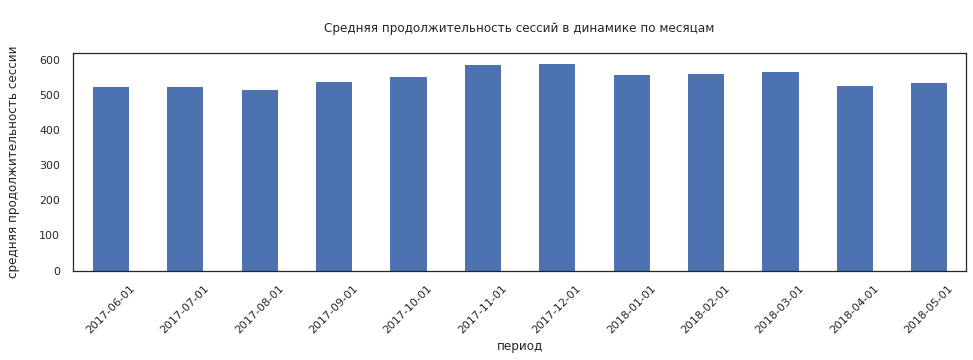

In [37]:
# сгруппируем визиты по месяцу и найдем среднюю продолжительность на каждый месяц
(visits
     .query('duration >= 0 and duration <= 3600')
     .groupby('month')['duration'].mean()
     .plot(kind = 'bar', figsize = (16, 4), rot = 45)
)

plt.title("\n" + 'Средняя продолжительность сессий в динамике по месяцам' + "\n")
plt.xlabel('период')
plt.ylabel("средняя продолжительность сессии" + "\n")
plt.show()

Средняя продолжительность сессии не менялась значительно от месяца к месяцу. <br>
В основном сессии длятся от 8 до 10 минут.

#### Как менялось кол-во сессий от месяца к месяцу?

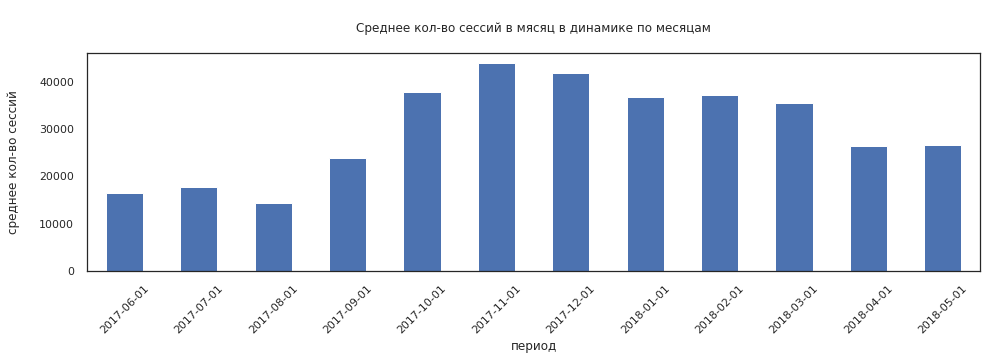

In [38]:
# средняя продолжительность сессий
visits.groupby('month')['start_session_time'].count().plot(kind = 'bar', figsize = (16, 4), rot = 45)

plt.title("\n" + 'Среднее кол-во сессий в мясяц в динамике по месяцам' + "\n")
plt.xlabel('период')
plt.ylabel("среднее кол-во сессий" + "\n")
plt.show()

После сентября 2017 года среднее кол-во сессий в сесяц значительно выросло. <br>
Скорее всего это связано с увеличением расходов на маркетинг, что в свою очереь привело много новых пользователей.

Проверим.

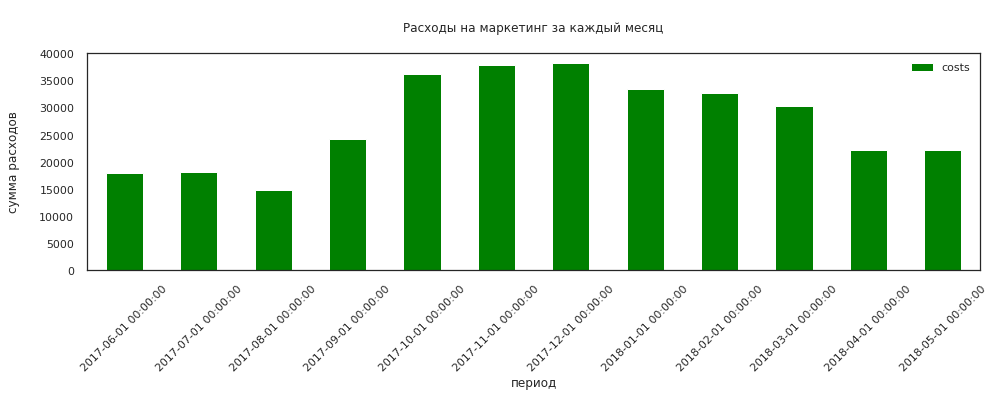

In [39]:
costs.groupby('month').agg({'costs': 'sum'}).plot(kind = 'bar', figsize = (16, 4), rot = 45, color = 'green')
plt.title("\n" + 'Расходы на маркетинг за каждый месяц' + "\n")
plt.xlabel('период')
plt.ylabel("сумма расходов" + "\n")
plt.show()

Действительно, с сентября 2017 года расходы на маркетинг увеличились.

Далее посмотрим на среднее кол-во сессий на пользователя в динамике.

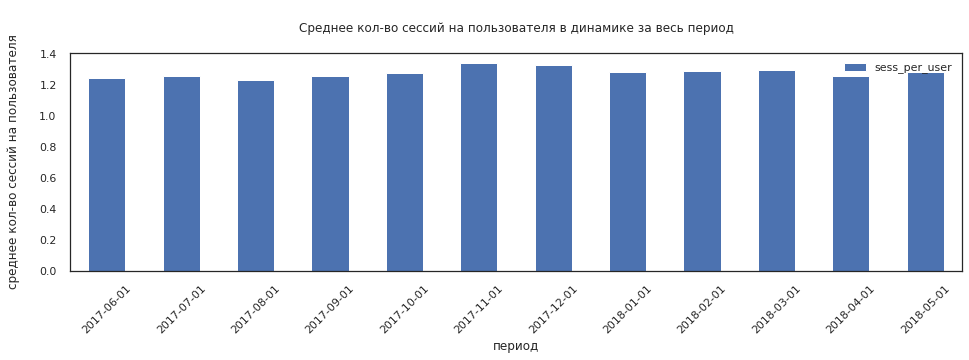

In [40]:
# как менялось среднее кол-во сессий в месяц на пользователя
sessions_per_user.plot(kind = 'bar',
                       x = 'month',
                       y = 'sess_per_user',
                       rot = 45,
                       figsize = (16, 4))


plt.title("\n" + 'Среднее кол-во сессий на пользователя в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("среднее кол-во сессий на пользователя" + "\n")
plt.show()

У среднего кол-во сессий на пользователя нет никакой динамики. <br>
Это значит, что поведение пользователей не менялось от месяца к месяцу и частота их визитов оставалась практически одинаковой от месяца к месяцу.

#### Как менялась активная месячная аудитория (MAU) от месяца к месяцу?

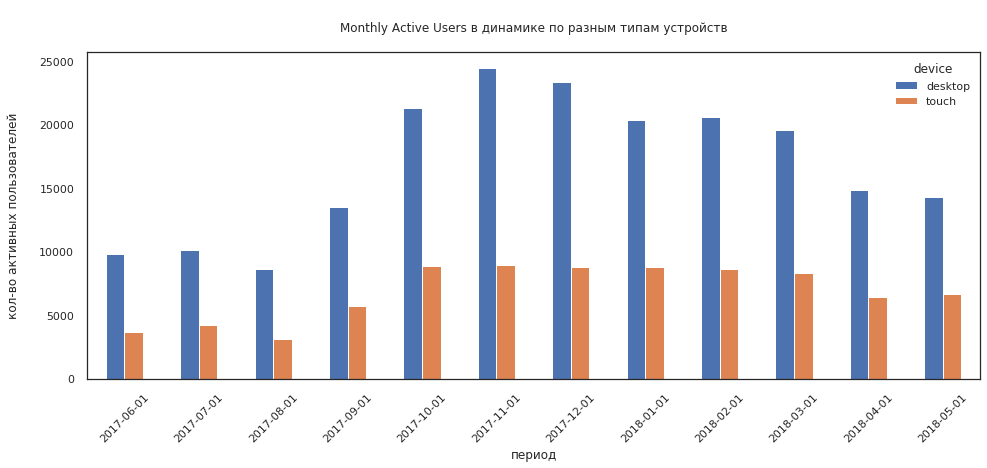

In [41]:
# посмотрим, как меняется MAU на разных типах устройств
(visits
         .pivot_table(
                        index = 'month',
                        columns = 'device',
                        values = 'uid',
                        aggfunc = 'nunique'
                      )
         .plot(kind = 'bar',
                 figsize = (16, 6),
                 rot = 45
              )
)
plt.title("\n" + 'Monthly Active Users в динамике по разным типам устройств' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во активных пользователей" + "\n")
plt.show()

Как мы предположили ранее, с сентября 2017 года увеличилось кол-во пользователей из-за увеличения расходов на маркетинг. <br>
На графике видно, что среднее кол-во активных пользователей в месяц выросло с этого же месяца.

Период наивысшей активности — ноябрь и декабрь. В эти месяцы на сайт заходят больше пользователей, чем обычно.

В апреле и мае наблюдается спад. Но это также связано с расходами на маркетинг и рейтингом удержания (график расходов выглядел точно также). <br>
Так как большинство привлеченных пользователей (95%) перестают заходить на сайт уже на следующий месяц, то кол-во активных пользователей сильно коррелирует с расходами на маркетинг: чем больше денег потратили, тем больше пользователей привели, тем выше MAU.

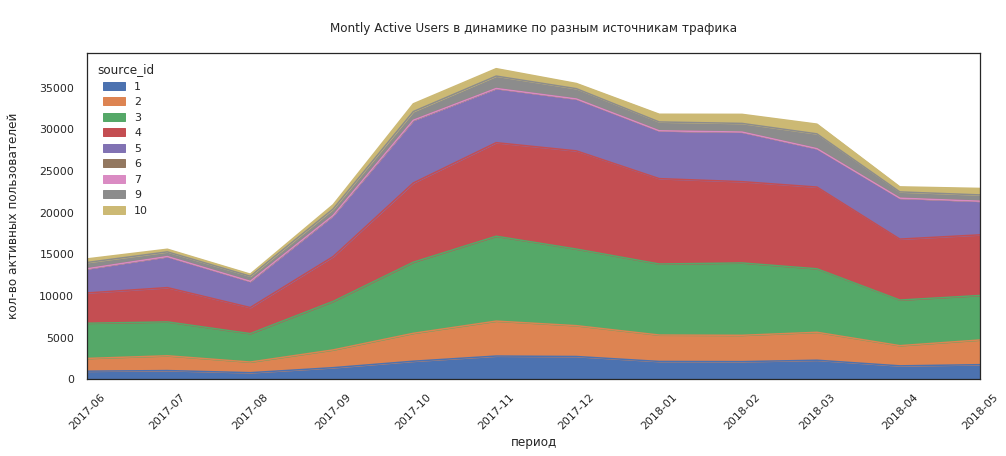

In [42]:
# посмотрим, как меняется MAU в разрезе разных источников трафика
(visits
         .pivot_table(
                        index = 'month',
                        columns = 'source_id',
                        values = 'uid',
                        aggfunc = 'nunique'
                      )
         .plot.area(
                 figsize = (16, 6),
                 rot = 45
              )
)
plt.title("\n" + 'Montly Active Users в динамике по разным источникам трафика' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во активных пользователей" + "\n")
plt.show()

Раз кол-во активных пользователей в месяц связано с расходами на маркетинг, то на это графике мы фактически видим объем привлеченных пользователей с каждого источника.

Так больше всего активных пользователей привели три канала: 4(красный), 3(зеленый) и 5(фиолетовый).

#### Как средняя продолжительность различается по устройствам?


Среднее время сессии на desktop за месяц: 10 мин


Среднее время сессии на touch за месяц: 7 мин



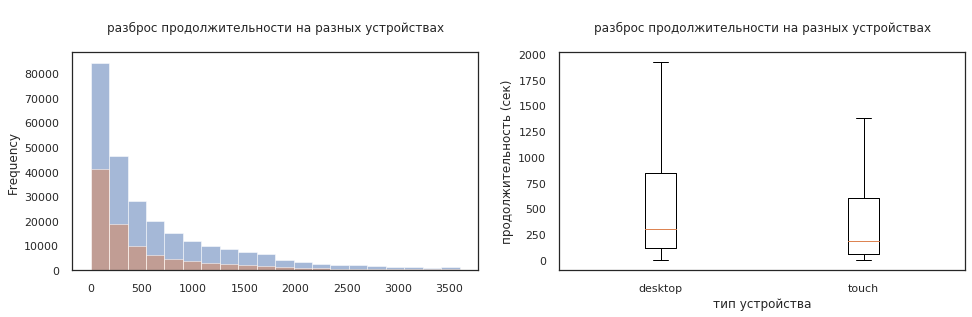

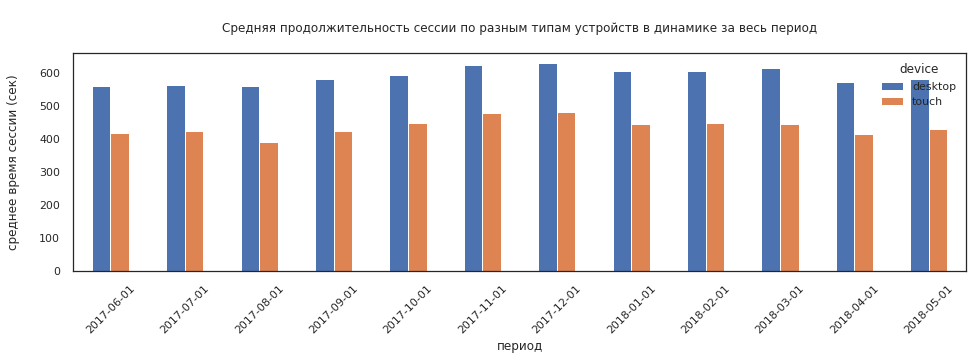

In [43]:
# создадим сводную таблицу
mean_duration_by_device = (visits
                               .query('duration >= 0 and duration <= 3600')
                               .pivot_table(values = 'duration',
                                            index = 'month',
                                            columns = 'device',
                                            aggfunc ='mean')
                          )


# построим график для сравнения среднего времени по устройствам
print("\n" + 'Среднее время сессии на desktop за месяц:', round(mean_duration_by_device.desktop.mean() / 60), 'мин' + "\n")
print("\n" + 'Среднее время сессии на touch за месяц:', round(mean_duration_by_device.touch.mean() / 60), 'мин' + "\n")
fig, (ax, ax2) = plt.subplots(ncols=2, figsize = (16, 4))
    
visits.query('device == "desktop" and duration >= 0 and duration <= 3600')['duration'].plot(kind = 'hist', alpha=0.5, bins = 20, ax = ax,)
visits.query('device == "touch" and duration >= 0 and duration <= 3600')['duration'].plot(kind = 'hist', alpha=0.5, bins = 20, ax = ax, title = ("\n" + 'разброс продолжительности на разных устройствах' + "\n"))
# plt.xlabel()
# plt.ylabel('частота встречаимости')
# plt.title('разброс продолжительности на разных устройствах')

plt.boxplot([visits.query('device == "desktop" and duration >= 0 and duration <= 3600')['duration'],
                   visits.query('device == "touch" and duration >= 0 and duration <= 3600')['duration']],
                   labels = ['desktop', 'touch'],
                   showfliers = False,
                  )
plt.xlabel('тип устройства')
plt.ylabel('продолжительность (сек)')
plt.title("\n" + 'разброс продолжительности на разных устройствах' + "\n")
plt.show()


# посмотрим на данные в динамике
mean_duration_by_device.plot(kind = 'bar',rot = 45,figsize = (16, 4))
plt.title("\n" + 'Средняя продолжительность сессии по разным типам устройств в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("среднее время сессии (сек)" + "\n")
plt.show()

Средняя продолжительность сессии на десктопе обычно выше, чем на тач-устройствах. <br>
В целом сессии с десктопа более разнообразны, чем сессии с тач.

#### Как средняя продолжительность сессии различается по источникам трафика?

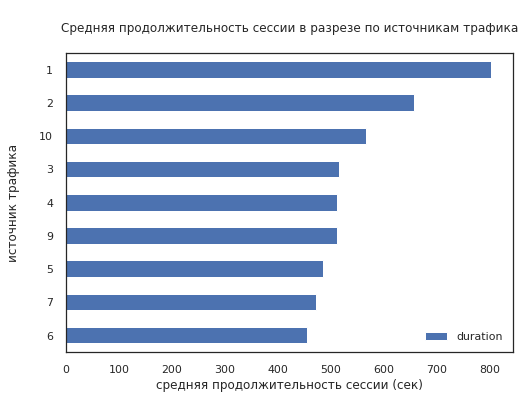

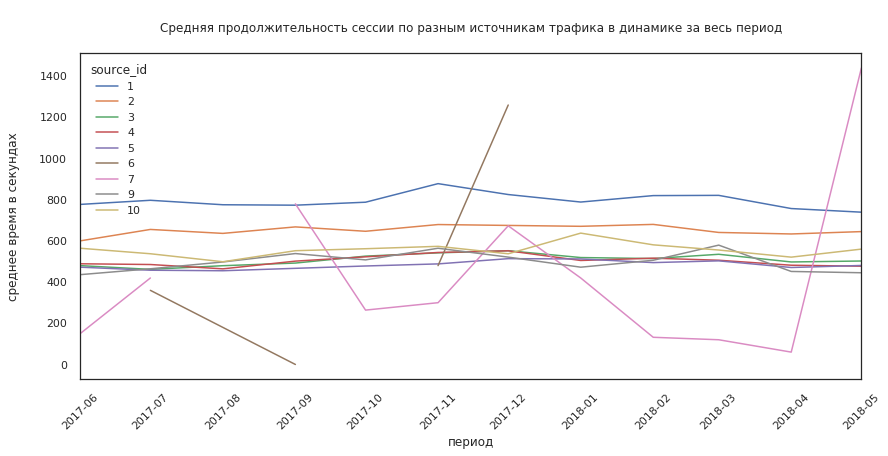

In [44]:
# сгруппируем данные по источнику трафика
mean_duration_by_source = (visits
                                   .query('duration >= 0 and duration <= 3600')
                                   .groupby(['source_id'])
                                   .agg({'duration': 'mean'})
                                   .sort_values(by = 'duration', ascending = True))

# построим график
mean_duration_by_source.plot(kind = 'barh')
plt.title("\n" + 'Средняя продолжительность сессии в разрезе по источникам трафика' + "\n")
plt.xlabel('средняя продолжительность сессии (сек)')
plt.ylabel("источник трафика" + "\n")
plt.show()

# посмотрим на данные в динамике
(visits
 .query('duration >= 0 and duration <= 3600')
 .pivot_table(values = 'duration',
              index = 'month',
              columns = 'source_id',
              aggfunc ='mean')
 .plot(figsize = (14, 6), rot = 45)
)
plt.title("\n" + 'Средняя продолжительность сессии по разным источникам трафика в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("среднее время в секундах" + "\n")
plt.show()

Средняя продолжительность сессии у пользователей, которые пришли из 1 канала самая высокая — около 13 минут. <br>
Пользователи из источника № 2 в среднем проводят на сайте около 10 минут. <br>

Пользователи с остальных устройств проводят на сайте около 6-9 минут.

У пользователей из 6 и 7 каналов странное поведение. Их привлекали нерегулярно и среднее время у них обычно ниже, чем у пользователей из других источников.

#### Как кол-во сессий в месяц различается по устройствам?


Среднее кол-во сессий на desktop в месяц: 21881 


Среднее кол-во сессий на touch в месяц: 8069 



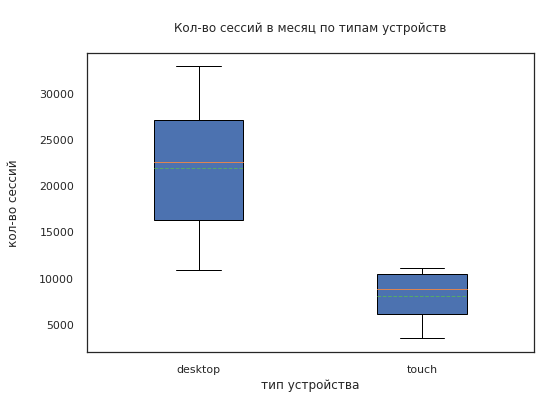

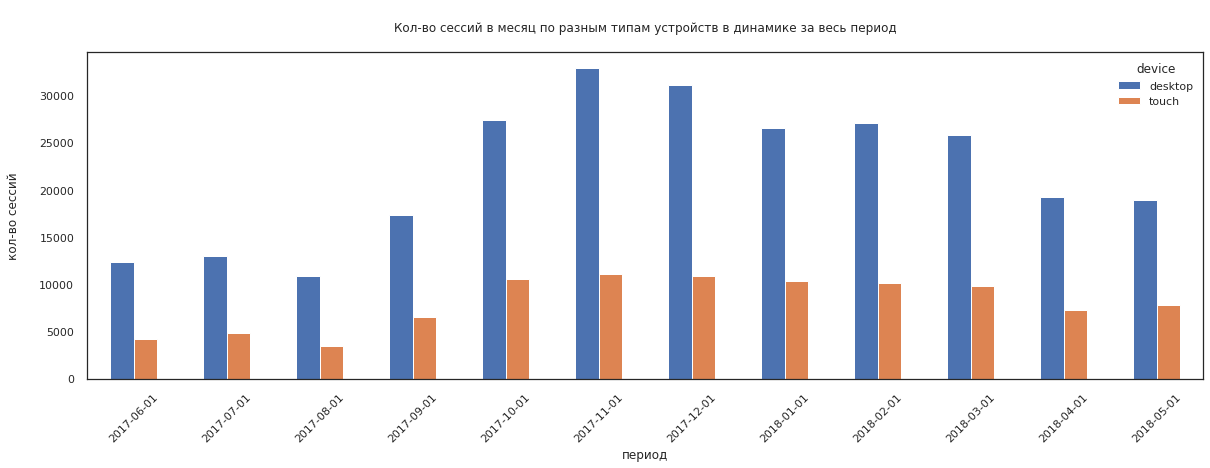

In [45]:
# создадим сводную таблицу
mean_sessions_by_device = visits.pivot_table(
                                        values = 'start_session_time', 
                                        index = 'month',
                                        columns = 'device',
                                        aggfunc ='count')

print("\n" + 'Среднее кол-во сессий на desktop в месяц:', round(mean_sessions_by_device.desktop.mean()), "\n")
print("\n" + 'Среднее кол-во сессий на touch в месяц:', round(mean_sessions_by_device.touch.mean()), "\n")
# построим график для сравнения среднего времени по устройствам
plt.boxplot(
                [mean_sessions_by_device['desktop'],mean_sessions_by_device['touch']],
                   labels = ['desktop', 'touch'],
                    showfliers = False,
                    autorange = True,
                    widths = 0.4,
                    patch_artist = True,
                    showmeans = True,
                    meanline = True
                  )
plt.title("\n" + 'Кол-во сессий в месяц по типам устройств' + "\n")
plt.xlabel("тип устройства" + "\n")
plt.ylabel("кол-во сессий" + "\n")
plt.show()


# посмотрим на данные в динамике
mean_sessions_by_device.plot(kind = 'bar', rot = 45, figsize = (20, 6))
plt.title("\n" + 'Кол-во сессий в месяц по разным типам устройств в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во сессий" + "\n")
plt.show()

Обычно количество сессий с десктопа примерно в 2-2,5 раза выше, чем кол-во сессий с тач-устройств. <br>
Скорее всего, это также связано с разделением бюджета на эти устройства (но об этом у нас нет данных).

#### Как кол-во сессий в месяц различается по рекламным источникам?

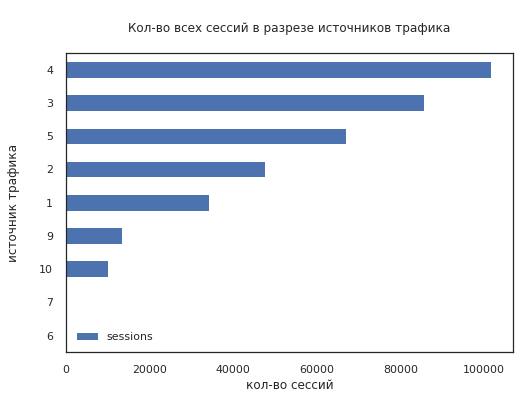

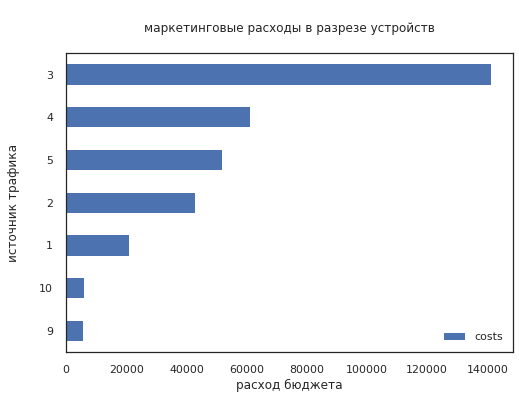

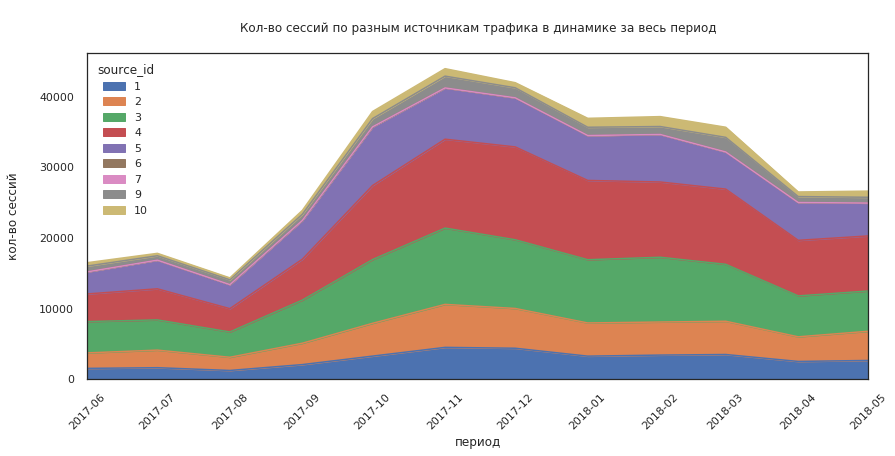

In [46]:
# посчитаем кол-во сессий в разрезе источников
mean_session_by_source = visits.groupby('source_id').agg({'uid': 'count'}).sort_values(by = 'uid', ascending = True)
mean_session_by_source = mean_session_by_source.rename(columns = {'uid': 'sessions'})

# посмотрим на кол-во сессий
mean_session_by_source.plot(kind = 'barh')
plt.title("\n" + 'Кол-во всех сессий в разрезе источников трафика' + "\n")
plt.xlabel('кол-во сессий')
plt.ylabel("источник трафика" + "\n")
plt.show()

# посмотрим на маркетинговые расходы в разрезе устройств
costs.groupby('source_id').agg({'costs': 'sum'}).sort_values('costs').plot(kind = 'barh')
plt.title("\n" + 'маркетинговые расходы в разрезе устройств' + "\n")
plt.xlabel('расход бюджета')
plt.ylabel("источник трафика" + "\n")
plt.show()

# посмотрим на данные в динамике
visits.pivot_table(
                    index = 'month',
                    values = 'start_session_time',
                    columns = 'source_id',
                    aggfunc ='count').plot.area(
                                            figsize = (14, 6),
                                            rot = 45)
plt.title("\n" + 'Кол-во сессий по разным источникам трафика в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во сессий" + "\n")
plt.show()

### Выводы о продуктовых метриках
[К оглавлению](#оглавление)<br>

В среднем за один месяц Яндекс.Афишу посещают 23 тысячи активных пользователей. <br>
В среднем за неделю — 5,7 тысяч. <br>
В день — 907. <br>

**Cессии и их время в разрезе устройств и каналов трафика.**<br>
Обычно на сайте бывает 987 сессий продолжительности около 10 минут. <br>
Больше всего сессий совершают с десктопа. Среднее время на этом типе устройств также обычно выше на 3 минуты.

Больше всего сессий приходят с 4, 3 и 5 каналов привлечения. При этом расход на 3 канал в 2 раза выше, чем на 4 и 5. <br>
Скорее всего в этом канале самые дорогие клиенты.

Пользователи из 1 и 2 канала обычно проводят больше времени на сайте, чем пользователи из других каналов. <br>
Хотя сессий из этих каналов обычно немного из-за небольшой доли бюджета.

**Активная аудитория и рейтинг удержания.**<br>

Количество активных пользователей в месяц сильно связано с расходом на привлечение новых пользователей: чем больше расход на маркетинг в месяц, тем больше активных пользователей за каждый месяц. <br>
Это связано с тем, что 94-95% привлеченных пользователей не приходят на сайт на следующий месяц. Поэтому активная аудитория каждого следующего месяца складывается из тех, кого в этот месяц привлекли, а не из тех, кто остался.

Это значит, что без постоянного привлечения пользователей (и новых и возврата старых) у Яндекс.Афиши будет очень маленькая активная база пользователей, которые сами пользуются сервисом.

Для Яндекс.Афиши это нормальная ситуация, так как по своей сути это сервис по продаже билетов, витрина. Пользователи обращаются к сервису только в момент возникновения потребности, а не используют его на постоянной основе. Сам сервис тоже не предполагает регулярных посещений. <br>
Потребность в свою очередь создается рекламой (= расходом на привлечение). Также она зависит от вкусов пользователей Например, любимых групп, на концерт которых стоит потратить деньги, у среднего пользователя немного и выступают они не часто. <br>
К тому же для пользователей видимо нет большой разницы, где именно покупать билеты. <br>

Продакт-менеджерам Яндекс.Афиши можно поработать над простыми механиками удержания. Но судя по самой модели бизнеса, можно сказать, что это не приведет к кратному увеличению Retention rate (на мой взгляд потолок для таких сервисов это до 10%). <br> 

Почему бы не попробовать интегрировать сервис с Яндекс.Музыкой и КинопоискHD, чтобы лучше понимать предпочтения пользователей и предлагать им билеты на подходящие события :)

### Метрики продаж

**Чек-лист:**
- [x] Когда люди начинают покупать?
- [x] Сколько раз покупают за период?
- [x] Какой средний чек?
- [x] Сколько денег приносят? (LTV)

#### Когда люди начинают покупать?

Для ответа на этот вопрос мы подготовили специальную таблицу. <br>
Воспользуемся ей, ограничив минимальное и максимально время сессий от 0 до 3600 секунд соответственно.

In [47]:
time_report.sample(5)

,uid,device,first_visit_day,first_order_day,days_bf_order,minutes_bf_order
12455,17349067567001963493,touch,2017-12-14,2018-02-05,53,77133.00
26522,10061839954874822423,desktop,2018-04-28,2018-04-28,0,1.00
9590,7910962378693156711,desktop,2017-10-05,2017-11-24,50,72010.00
17666,9586596186875332354,desktop,2017-07-07,2017-07-11,4,5424.00
4825,14788873542714768166,desktop,2017-12-03,2017-12-03,0,9.00


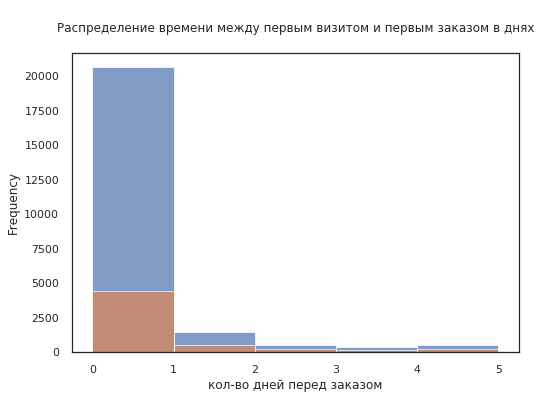


Среднее количество дней до первой покупки: 17 


Среднее количество дней до первой покупки на десктопе: 16 


Среднее количество дней до первой покупки на тач-устройствах: 20 


Доля пользователей, которые покупают билеты в свой первый визит: 69 %


In [48]:
# посмотрим на распределение количества дней перед покупкой сразу в разрезе устройств

time_report.query('device == "desktop"')['days_bf_order'].plot(kind = 'hist', alpha=0.7, bins = 5, range = (0, 5))
time_report.query('device == "touch"')['days_bf_order'].plot(kind = 'hist', alpha=0.7, bins = 5, range = (0, 5))
plt.title("\n" + 'Распределение времени между первым визитом и первым заказом в днях' + "\n")
plt.xlabel('кол-во дней перед заказом')
plt.show()

print("\n" + 'Среднее количество дней до первой покупки:', round(time_report.days_bf_order.mean()), "\n")

print("\n" + 'Среднее количество дней до первой покупки на десктопе:',
      round(time_report.query('device == "desktop"').days_bf_order.mean()), "\n")

print("\n" + 'Среднее количество дней до первой покупки на тач-устройствах:',
      round(time_report.query('device == "touch"').days_bf_order.mean()), "\n")

print("\n" + 'Доля пользователей, которые покупают билеты в свой первый визит:',
      round(len(time_report.query('first_order_day == first_visit_day')) / len(time_report) * 100), "%")

Среднее количество дней до покупки сильно завышается из-за пользователей, которые не покупают в первый день. <br>
Таких пользователей 31%. Остальные 69% покупают билеты в день первого визита

При этом большинство покупой совершают с десктопа: таких покупок почти в 5 раз больше, чем с мобильных устройств (так как и сессий с этого типа устройств тоже больше).

Изучим, какое среднее время до покупки у тех, кто купил в день первого визита.

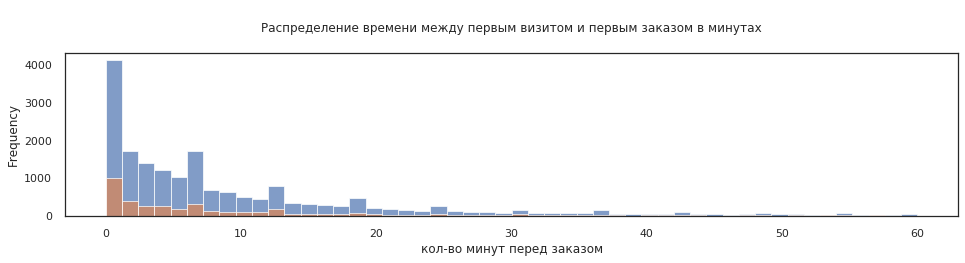


Среднее количество минут до первой покупки на десктопе в день первого визита: 31 


Среднее количество минут до первой покупки на тач-устройствах в день первого визита: 44 



In [49]:
# сделаем срез только с теми заказами, которые случились в день первого визита
time_report_same_day = time_report.query('first_order_day == first_visit_day')

# посмотрим на распределение времени до покупки на разных типах устройств
time_report_same_day.query('device == "desktop"')['minutes_bf_order'].plot(kind = 'hist',
                                                                           alpha=0.7,
                                                                           bins = 50,
                                                                           range = (0, 60),
                                                                           figsize = (16,3))

time_report_same_day.query('device == "touch"')['minutes_bf_order'].plot(kind = 'hist',
                                                                         alpha=0.7,
                                                                         bins = 50,
                                                                         range = (0, 60),
                                                                         figsize = (16,3))

plt.title("\n" + 'Распределение времени между первым визитом и первым заказом в минутах' + "\n")
plt.xlabel('кол-во минут перед заказом')
plt.show()

print("\n" + 'Среднее количество минут до первой покупки на десктопе в день первого визита:',
      round(time_report_same_day.query('device == "desktop"').minutes_bf_order.mean()), "\n")

print("\n" + 'Среднее количество минут до первой покупки на тач-устройствах в день первого визита:',
      round(time_report_same_day.query('device == "touch"').minutes_bf_order.mean()), "\n")

Чаще всего пользователи тратят на покупки меньше минуты! Вероятно такие пользователи уже знают, за чем приходят. <br>
Однако таких пользователей не больше 20-23%. Большинство пользователей (75%) тратят на покупку не более 18 минут.


<br>

**Выводы:**
Большинство пользователей совершают покупку в первый день в течение получаса.

1. 69% посетитилей сайта Яндекс.Афиши совершают покупку в день своего первого визита.
2. 75% из этих пользователей тратят на покупку билета не более 18 минут, а в среднем всем "покупателям первого дня" требуется около получаса. 
3. В среднем тем, кто первый раз посетил сайт с тач-устройства и купил билет в первый день, на покупку нужно на 13 минут больше, чем тем, кто пришел с десктопа и купил в первый день.
4. В среднем пользователям нужно от 17 дней на первую покупку. Значит, следует рекламировать события заранее на протяжении месяца.

#### Какой средний чек и как он менялся? 

Для начала изучим средний чек за весь период.

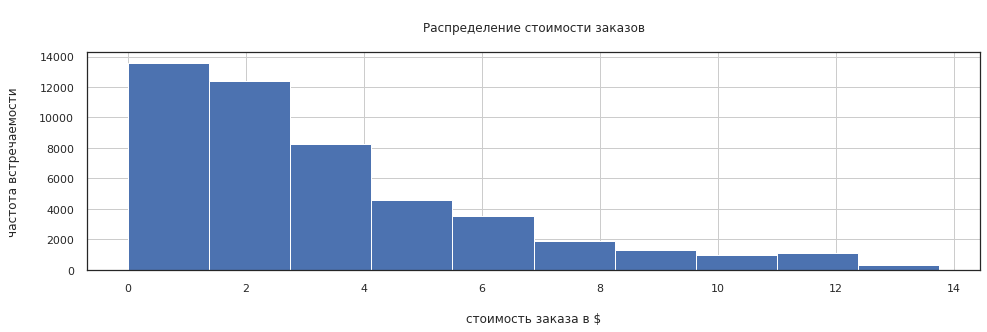


Средний чек в целом по сайту: 5.0 $


Половина всех заказов стоит не более: 2.5 $



In [50]:
orders.revenue.hist(figsize = (16,4), range = (0, orders.revenue.quantile(0.95)))
plt.title("\n" + 'Распределение стоимости заказов' + "\n")
plt.ylabel('частота встречаемости' + "\n")
plt.xlabel("\n" + 'стоимость заказа в $')
plt.show()

print("\n" + 'Средний чек в целом по сайту:', round(orders.revenue.mean(), 2), '$' + "\n")

print("\n" + 'Половина всех заказов стоит не более:', orders.revenue.median(), '$' + "\n")

#### Средний чек на разных устройствах

Посмотрим, как средний чек различается на разных устройствах.

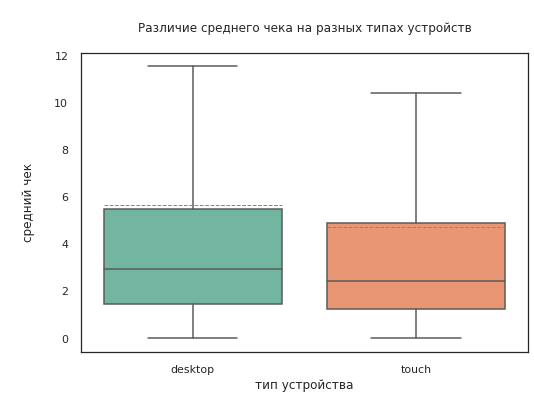


Средний чек с десктопа: 5.16 $


Средний чек с тач-устройств: 4.29 $



In [51]:
sns.boxplot(
            x = 'device',
            y = 'revenue',
            data = orders.groupby(['order_time']).agg({'device':'first','revenue':'sum'}),
            showfliers = False,
            showmeans = True,
            meanline = True,
            palette = 'Set2'
            )

plt.title("\n" + 'Различие среднего чека на разных типах устройств' + "\n")
plt.ylabel("\n" + 'средний чек'  + "\n")
plt.xlabel("тип устройства" + "\n")
plt.show()

print("\n" + 'Средний чек с десктопа:', round(orders.query('device == "desktop"').revenue.mean(), 2), '$' + "\n")

print("\n" + 'Средний чек с тач-устройств:', round(orders.query('device == "touch"').revenue.mean(), 2), '$' + "\n")

Размер среднего чека с десктопа на 87 центов больше, чем с тач-устройств. <br>
Размер половины всех заказов с десктопа не превышает 3$. С тач-устройств меньше.

Стоимость заказов с десктопа более разнообразна, чем с мобайла (судя по интервартильному размаху). <br>
Однако распределения стоимости заказов на обоих устройствах очень похожи и вряд ли это различие статистически значимо.

#### Средний чек по разным рекламным каналам

Посмотрим, как средний чек различается у людей пришедших из разных каналов привлечения.

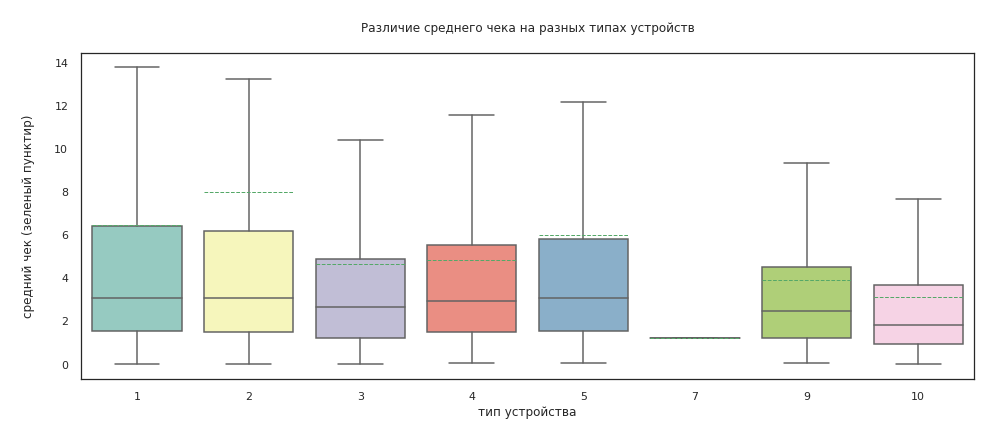

In [52]:
plt.figure(figsize=(16, 6))
sns.boxplot(
            x = 'source_id',
            y = 'revenue',
            data = orders.groupby(['order_time']).agg({'source_id':'first','revenue':'sum'}),
            showfliers = False,
            showmeans = True,
            meanline = True,
            palette = 'Set3'
            )

plt.title("\n" + 'Различие среднего чека на разных типах устройств' + "\n")
plt.ylabel("\n" + 'средний чек (зеленый пунктир)' + "\n")
plt.xlabel("тип устройства" + "\n")
plt.show()

Заметно выделяется второй канал привлечения: размер среднего чека здесь около 8%. Однако само распределение выглядит уже, чем распределение первого источника, у которого средний чек ниже. Так на размер среднего чека влияют аутлаеры - редкие заказы большой стоимости.

В этом случае стоит смотреть на медианные зачения. С 1 по 5 каналы они практически не различаются и находятся в пределах 2,5 - 3$. 

7 канал трафика — некий случайный визит, который ни о чем не говорит.

В 9 и 10 каналах медианный размер чека ниже, чем в других каналах. На эти каналы тратят меньше всего денег и они приносят меньше всего трафика.

#### Динамика среднего чека

Далее изучим, как меняется средний чек со временем.

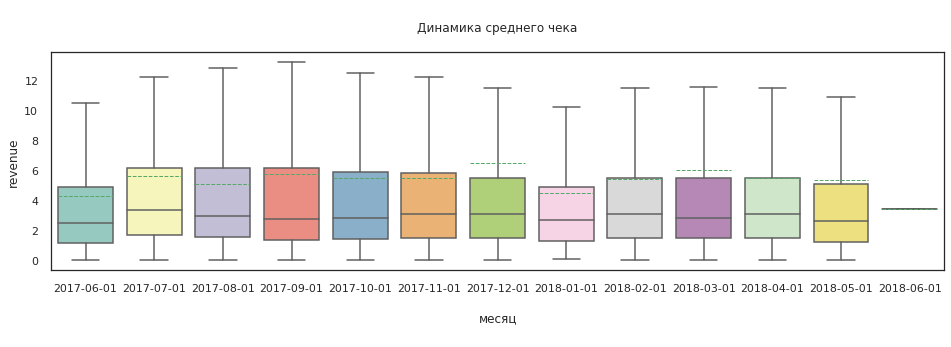

In [53]:
plt.figure(figsize=(16, 4))
sns.boxplot(
            x = 'order_month',
            y = 'revenue',
            data = orders.groupby(['order_time']).agg({'order_month':'first','revenue':'sum'}),
            showfliers = False,
            showmeans = True,
            meanline = True,
            palette = 'Set3'
            )

plt.title("\n" + 'Динамика среднего чека' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()

Особой динамики в размере среднего чека от месяца к месяцу нет. <br>
Средний чек сильно вырастает в декабре и марте: примерно до 6-6,3$. <br>
В Июне 2018 года практически не было заказов, потому о среднем чеке сказать ничего нельзя.

#### Средний чек по когортам

Изучим, как средний чек меняется в разных когортах.

In [54]:
orders.head()

,order_time,revenue,uid,first_order_time,first_order_month,order_month,acquisition_month,source_id,device,cac,cohort_age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01,1,desktop,3.13,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01,3,desktop,7.60,0


In [55]:
# сгруппируем отчет по пользователям таким образом,
# чтобы сформировать когорты по месяцу привлечения пользователя
# и для каждой когорты найти кол-во заказов и общую выручку
# и затем рассчитать среднюю выручку с одного пользователя

orders_grouped_by_cohorts = (orders
                                     .groupby(['acquisition_month','order_month'])
                                     .agg({'uid': 'nunique', 'order_time':'count','revenue':'sum'})
                            )

orders_grouped_by_cohorts = (orders_grouped_by_cohorts
                             .rename(columns = {'uid': 'n_buyers', 'order_time': 'orders', 'revenue': 'total_revenue'})
                            )

#посчитаем средний чек для каждой когорты на каждый месяц
orders_grouped_by_cohorts['avg_check'] = orders_grouped_by_cohorts['total_revenue'] / orders_grouped_by_cohorts['orders']
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index().set_index('acquisition_month')
orders_grouped_by_cohorts.head()

,order_month,n_buyers,orders,total_revenue,avg_check
acquisition_month,,,,,
2017-06-01,2017-06-01,2023,2354,9557.49,4.06
2017-06-01,2017-07-01,231,387,2664.58,6.89
2017-06-01,2017-08-01,129,273,1464.69,5.37
2017-06-01,2017-09-01,188,442,3882.09,8.78
2017-06-01,2017-10-01,257,516,3940.59,7.64


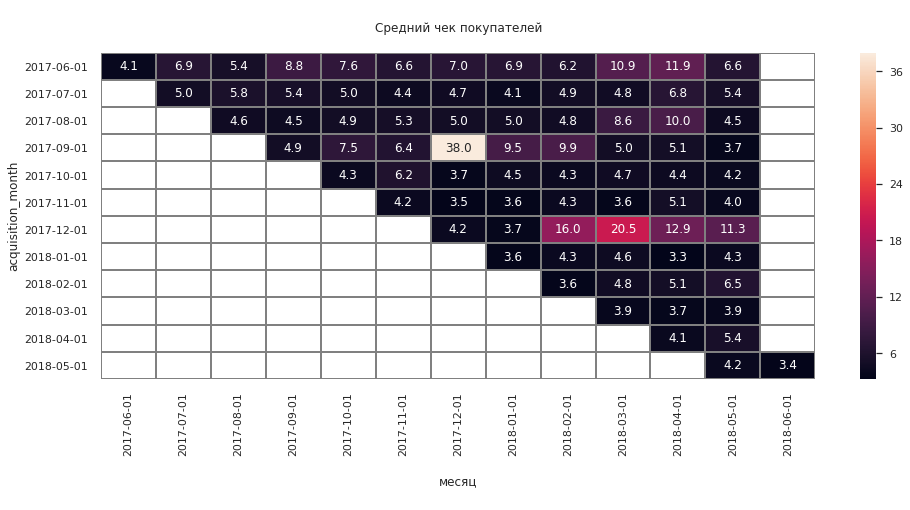

In [56]:
# сделаем сводную таблицу для когортного анализа
avg_revenue = orders_grouped_by_cohorts.pivot_table(
                                        index='acquisition_month',
                                        columns='order_month',
                                        values='avg_check',
                                        aggfunc='mean')

plt.figure(figsize=(16, 6))

sns.heatmap(avg_revenue, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Средний чек покупателей' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()

Самый высокий средний чек в месяц обычно был у когорты покупателей, которых привлекли в июне 2017 года. За 12 месяцев средний чек был ниже 6 долларов лишь дважды и выростал почти до 12$ в апреле. <br>

Также выделяется когорта сентября 2017 года: с октября по февраль 2018 средний чек был выше среднего чека по сайту.

Другая примечательная когорта — декабрьская. В ней уже с февраля средний чек превышает 11$, что в 2 раза больше, чем средний чек по сайту.

В других когортах такой стабильности нет: чаще средний чек незначительно превышал средний чек по сайту на несколько центов.


**Выводы:**
1. Половина всех заказов на сайте стоят не более 2,5 долларов
2. Средний чек по сайту 5 даллоров
3. Средний чек с десктопа выше на 87 центов, чем с тач-устройств
4. Топ-3 каналов по среднему чеку в порядке убывания: 2, 5, 1
5. Средний чек практически не изменяется от месяца к месяцу, но повышается в декабре и марте
6. Лучшие когорты по размеру среднего чека: июньская, сентябрьская и декабрьская

#### Сколько раз покупают за период?

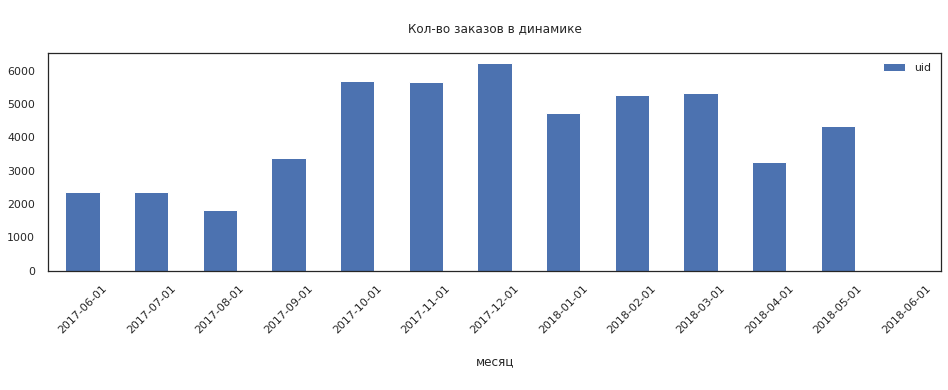


Средний кол-во заказов в месяц: 3878 



In [57]:
# сгруппируем таблицу с заказами по месяцу заказа и на каждый месяц найдем кол-во заказов
orders.groupby('order_month').agg({'uid':'count'}).plot(kind = 'bar', figsize = (16,4), rot = 45)
plt.title("\n" + 'Кол-во заказов в динамике' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()


print(
        "\n" + 'Средний кол-во заказов в месяц:',
        round(orders.groupby('order_month')['uid'].count().mean()),
        "\n"
      )

Узнаем сколько в среднем один пользователь делает заказов в месяц.

In [58]:
# сгруппируем таблицу с заказами по месяцу и на каждый месяц посчитаем кол-во уникальных пользвателей и кол-во заказов в месяц
orders_per_buyer = orders.groupby('order_month').agg({'uid': 'nunique', 'order_time': 'count'})
orders_per_buyer = orders_per_buyer.rename(columns = {'uid': 'buyers', 'order_time': 'orders'})

# разделим кол-во заказов на кол-во пользователей, чтобы найти среднее кол-во
orders_per_buyer['orders_per_buyer'] = orders_per_buyer['orders'] / orders_per_buyer['buyers']

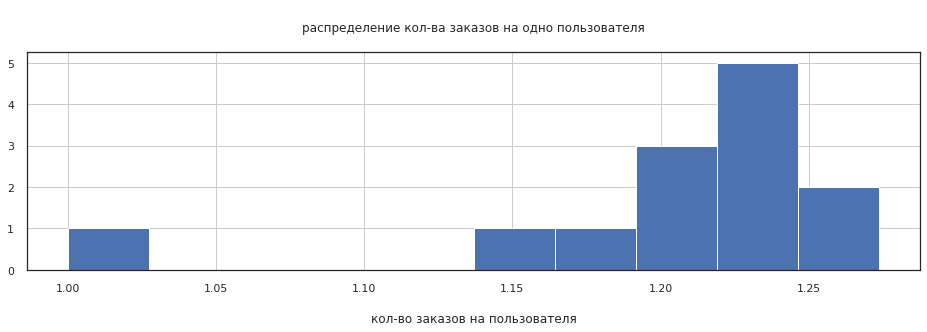


среднее кол-во заказов на одного пользователя в месяц: 1.23 



In [59]:
# посмотрим на распределение значений среднего кол-ва заказов за 12 месяцев
orders_per_buyer['orders_per_buyer'].hist(figsize = (16,4))
plt.title("\n" + 'распределение кол-ва заказов на одно пользователя' + "\n")
plt.xlabel("\n" + 'кол-во заказов на пользователя')
plt.show()

print(
        "\n" + 'среднее кол-во заказов на одного пользователя в месяц:',
        round(orders_per_buyer.orders.sum() / orders_per_buyer.buyers.sum(), 2), "\n"
      )

В среднем за месяц пользователи сайта совершают 3878 заказов.

В среднем один пользователь делает 1.23 заказа (некоторые пользователи покупают и второй раз). <br>
Учитывая Retention Rate следующего месяца в 5-6% для каждой когорты, можно сказать, что большинство пользователей не возвращаются после первой покупки.

#### Сколько денег приносят когорты? Revenue & LTV

#### Выручка с каждой когорты в динамике

In [60]:
revenue_per_month = (orders
                             .pivot_table(index='acquisition_month',
                                            columns='order_month',
                                            values='revenue',
                                            aggfunc='sum')
      )

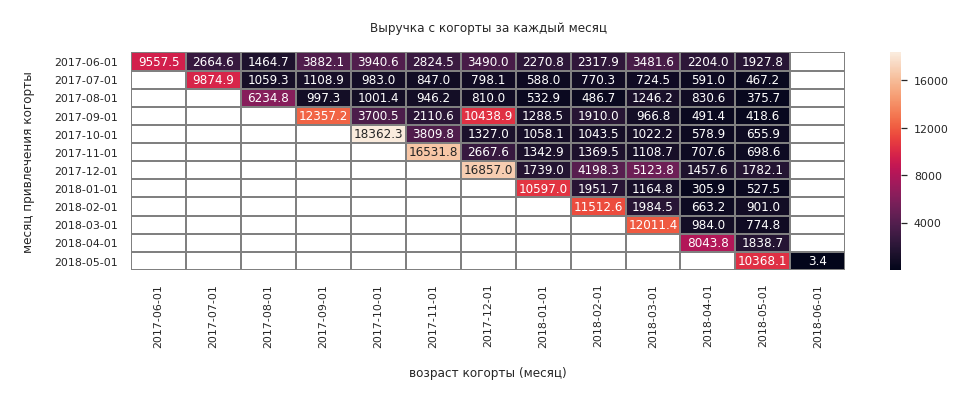


Средний доход с одной когорты по её возрасту:


In [61]:
plt.figure(figsize=(16, 4))

sns.heatmap(revenue_per_month, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Выручка с когорты за каждый месяц' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()
print("\n" + 'Средний доход с одной когорты по её возрасту:')


После месяца привлечения выручка в каждой когорте падает в 3-6 раз. Это можно объяснить низким показателем retention. <br>

Раз бизнес зарабатывает в основном на покупках за первый месяц, то и выводы следует делать исходя из сравнения выручки за первый месяц. <br>
Так можно выделить когорты с сентября 2017 по март 2018 года: в это время увеличивался маркетинговый бюджет и маркетологи привлекли больше пользователей, которые принесли больше выручки, чем другие когорты.

Также выделяется самая первая когорта (июнь 2017): объемы выручки за каждый месяц в этой когорте чаще всего больше, чем у других когорт. Маркетологам стоит выяснить, что именно привело такой качественный трафик.

Немного упростим посмотрим на значения поменьше — средний доход с пользователя.

#### Средняя выручка с одного клиента в когорте (LTV)

In [62]:
print("\n" + 'Средняя выручка с одного клиента за весь год:', round(orders.revenue.sum() / orders.uid.nunique(), 1))


Средняя выручка с одного клиента за весь год: 6.9


Далее посмотрим на средний LTV на каждый месяц в каждой когорте.

In [63]:
# создадим таблицу с численностью каждой когорты покупателей, сформированой по месяцу первого посещения
cohort_sizes = orders.groupby('acquisition_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['acquisition_month', 'n_buyers']
cohort_sizes.head()

,acquisition_month,n_buyers
0,2017-06-01,2923
1,2017-07-01,2458
2,2017-08-01,1721
3,2017-09-01,3058
4,2017-10-01,4678


In [64]:
# найдем доход на каждый месяц
cohorts = orders.groupby(['acquisition_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,acquisition_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,2664.58
2,2017-06-01,2017-08-01,1464.69
3,2017-06-01,2017-09-01,3882.09
4,2017-06-01,2017-10-01,3940.59


In [65]:
# соединим таблицы, получим таблицу с первоначальным размером каждой когорты и выручки с каждой когорты за каждый месяц
ltv_by_user = pd.merge(cohort_sizes, cohorts, on='acquisition_month')

# посчитаем возраст каждой когорты
ltv_by_user['age'] = (ltv_by_user['order_month'] - ltv_by_user['acquisition_month']) / np.timedelta64(1, 'M')
ltv_by_user['age'] = ltv_by_user['age'].round().astype('int')

# посчитаем средний доход с пользователя
ltv_by_user['ltv'] = ltv_by_user['revenue'] / ltv_by_user['n_buyers']

# приведем столбцы с датами к более подходящему для графиков виду (чтобы не было миллиона нулей после даты)
ltv_by_user['acquisition_month'] = ltv_by_user['acquisition_month'].astype('datetime64[M]').dt.date
ltv_by_user['order_month'] = ltv_by_user['order_month'].astype('datetime64[M]').dt.date

ltv_by_user.head()

,acquisition_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2923,2017-06-01,9557.49,0,3.27
1,2017-06-01,2923,2017-07-01,2664.58,1,0.91
2,2017-06-01,2923,2017-08-01,1464.69,2,0.50
3,2017-06-01,2923,2017-09-01,3882.09,3,1.33
4,2017-06-01,2923,2017-10-01,3940.59,4,1.35


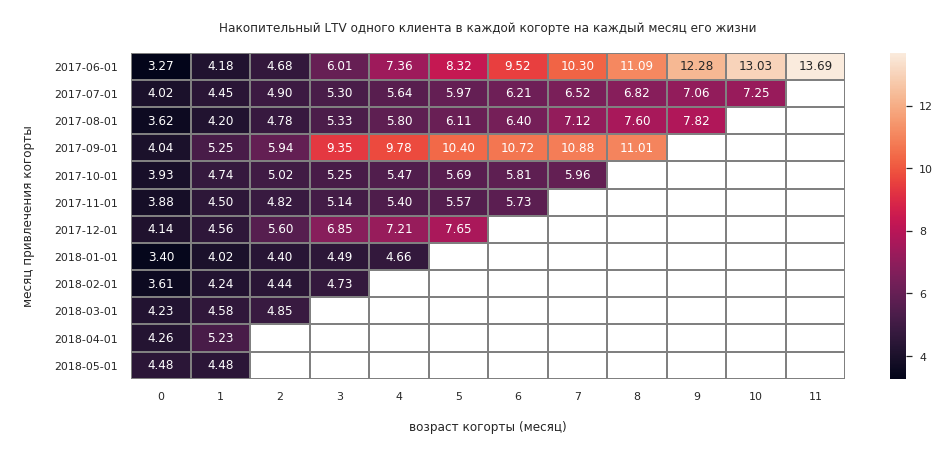

Средняя стоимость привлечения одного покупателя: 9.01 $



In [66]:
# построим сводную таблицу с накопительной выручкой с одного клиента

ltv_by_user_pivot = ltv_by_user.pivot_table(
        index='acquisition_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1)
    
# визуализируем
plt.figure(figsize=(16, 6))
sns.heatmap(ltv_by_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Накопительный LTV одного клиента в каждой когорте на каждый месяц его жизни' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()


# сравним со средней стоимостью привлечения одного платящего пользователя
print('Средняя стоимость привлечения одного покупателя:', round(costs.costs.sum() / orders.uid.nunique(), 2), '$' + "\n")

Снова можно выделить первую и сентябрьские когорты. Только в них в уже к 8 месяцу нокопителя выручка с одного клиента достигает значения выше 10 долларов (что почти в 3-4 раза выше, чем выручка за первый месяц).

В остальных когортах (за исключением декабрьской) выручка на одного клиента накапливается очень медленно.

По первому месяцу между когортами не видно значительной разницы между выручкой.

Сравнивая среднюю стоимость привлечения по всем каналам со средней выручкой на клиента в разных когортах, еще нельзя сделать вывод об окупаемости когорт (так как нужно смотреть на стоимость привлечения в каждой когорте).

Однако предварительно кажется, что окупились только июньская и сентябрьские когорты.

Проверим эту гипотезу в следующем разделе.

### Выводы о показателях продаж
[К оглавлению](#оглавление)<br>

69% пользователей совершают покупку в день своего первого визита. <br>
75% из этих пользователей на покупку тратят до 18% минут. <br>
В среднем всем покупателям "первого дня" на покупку нужно около получаса. С десктопа покупают быстрее, чем с тач-устройств.

В среднем за месяц на сайте совершают 3878 заказов. <br>
Один пользователь в среднем совершает полтора заказа. (тут я бы сказал, что один все-таки; нельзя так писать)

Полвина всех заказов на сайте стоят не более 2,5 долларов. <br>
Средний чек — 5 долларов. на десктопе он обычно выше, чем на таче, но всего на 87 центов. <br>
Средний чек выше у пользователей, привлеченных из 2, 5 и 1 каналов. <br>
От месяца к месяцу средний чек практически не меняется, за исключением декабря и марта (в эти месяцы он немного выше). <br>
Лучшие когорты по размеру среднего чека: июньская, сентябрьская и декабрьская.

В среднем общая выручка в каждой когорте за пол года достигает 6-7 долларов, что ниже средней стоимости привлечения одного клиента. <br>
Заметно выделяются только июньская и сентябрьская когорты 2017 года. В них выручка с одного клиента накапливается быстро и уже к 9 месяцу жизни когорты досгиает 10 долларов. <br>
В остальных когортах выручка растет очень медленно.
***

### Метрики маркетинга

**Чек-лист:**
- [x] Сколько всего денег потратили?
- [x] Сколько денег потратили в разрезе разных периодов (по времени)?
- [x] Сколько денег потратили в разрезе разных источников?
- [x] Сколько стоило привлечение одного покупателя из каждого источника?
- [x] На сколько окупились расходы? (ROI)

#### Сколько всего потратили денег? Сколько потратили в разрезе разных периодов?

In [67]:
# сгруппируем таблице с маркетинговыми расходами по месяцу и посчитаем расход за каждый месяц
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()
monthly_costs['month'] = monthly_costs['month'].dt.date
monthly_costs.head(15)

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


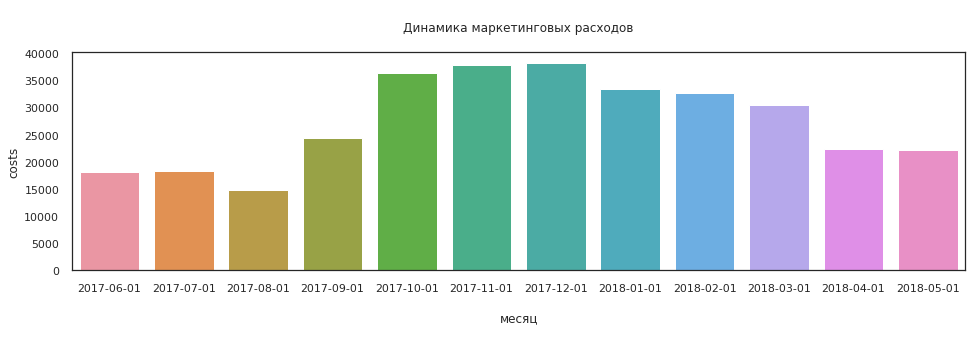

За весь период на привлечение пользователей потратили: 329131.62 $

Средний расход на маркетинг за месяц: 27427.63 $



In [68]:
# посмотрим на расходы в динамике

plt.figure(figsize=(16, 4))
sns.barplot(data=monthly_costs, 
            x ="month",
            y="costs", 
            ci= None)
plt.title("\n" + 'Динамика маркетинговых расходов' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()

print('За весь период на привлечение пользователей потратили:', round(monthly_costs.costs.sum(), 2), '$' + "\n")
print('Средний расход на маркетинг за месяц:', round(monthly_costs.costs.mean(), 2), '$' + "\n")

Мы уже видели этот график прежде: увеличение расходов на маркетинг с сентября привело к увеличению активный пользователей и увеличению выручки.

#### Сколько денег потратили на каждый источник?

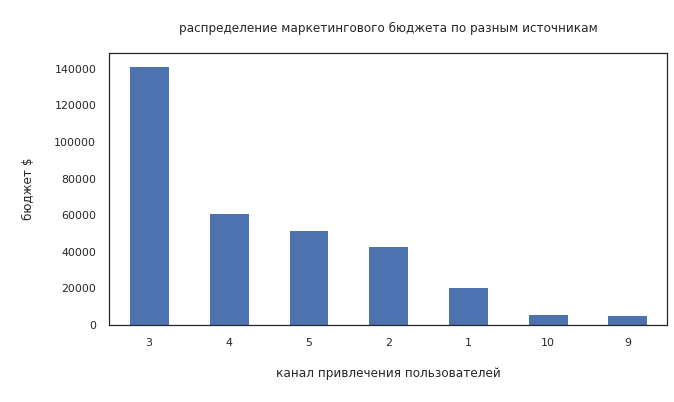

In [71]:
# сгруппируем таблицу с костами по источнику трафика и посчитаем сумму расходов для каждого
costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'})

# визуализируем
costs_by_source.sort_values('costs', ascending = False).costs.plot(kind = 'bar', figsize = (10,5), rot = 0)
plt.title("\n" + 'распределение маркетингового бюджета по разным источникам' + "\n")
plt.ylabel("\n" + 'бюджет $' + "\n")
plt.xlabel("\n" + 'канал привлечения пользователей' + "\n")
plt.show()

Основную часть бюджета потратили на третий источник. <br>
Далее в приоритете были 4, 5 и 2 источники. <br>
10 и 9 каналы получили меньше всего бюджета (и соответственно привели меньше всего клиентов <br>

Интересно сравнить расходны на каналы с полученной с них выручкой.

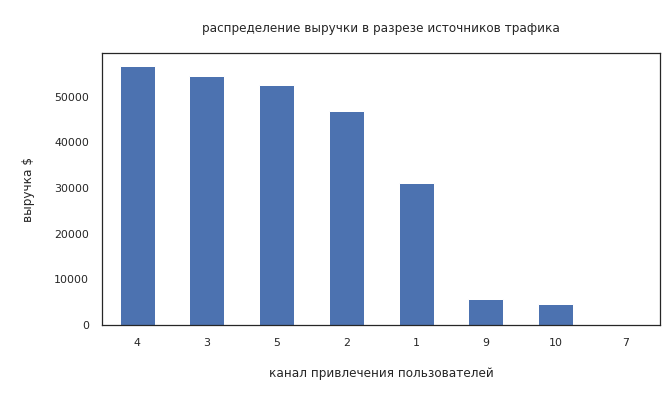

In [72]:
# сгруппируем таблицу с заказами по источнику трафика и посчитаем выручку для каждого
rev_by_source = orders.groupby('source_id').agg({'revenue': 'sum'})

# визуализируем
rev_by_source.sort_values('revenue', ascending = False).revenue.plot(kind = 'bar', figsize = (10,5), rot = 0)
plt.title("\n" + 'распределение выручки в разрезе источников трафика' + "\n")
plt.ylabel("\n" + 'выручка $' + "\n")
plt.xlabel("\n" + 'канал привлечения пользователей' + "\n")
plt.show()

Не смотря на то, что 3 канал получил в 2-2,5 раза больше бюджета чем 4 и 5 каналы, он принес сравнимый с этими каналами объем выручки. <br>

Видимо, канал оказался не так хорош, и стоимость привлечения одного пользователя с него должна оказаться самой высокой.

Второй канал принес чуть меньше выручки, чем пятый.

#### Сколько стоило привлечение одного покупателя из разных источников?

In [73]:
# сгруппируем таблицу с заказами по источнику трафика и найдем кол-во уникальных пользователей в каждом
buyers_cohorts_by_source = (orders.groupby('source_id')
                  .agg({'uid': 'nunique'})
                  .rename(columns = {'uid': 'cohort_size'})
                 )

# найдем затраты на каждый источник
cohort_costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'})

# соединим таблицы
buyers_cohorts_by_source = buyers_cohorts_by_source.join(cohort_costs_by_source)

# найдем среднюю стоимость привлечения одного клиента в каждом источнике
buyers_cohorts_by_source['cac'] = buyers_cohorts_by_source['costs'] / buyers_cohorts_by_source['cohort_size']
buyers_cohorts_by_source

,cohort_size,costs,cac
source_id,,,
1,2899,20833.27,7.19
2,3506,42806.04,12.21
3,10473,141321.63,13.49
4,10296,61073.60,5.93
5,6931,51757.10,7.47
7,1,nan,nan
9,1088,5517.49,5.07
10,1329,5822.49,4.38


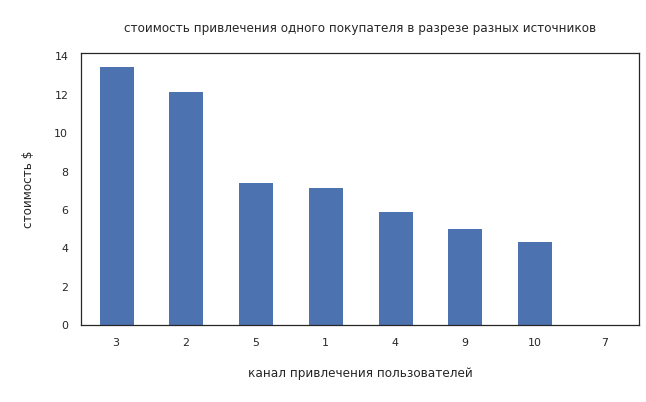

In [74]:
# визуализируем
(buyers_cohorts_by_source['cac']
             .sort_values(ascending = False)
             .plot(kind = 'bar', figsize = (10,5), rot = 0)
)

plt.title("\n" + 'стоимость привлечения одного покупателя в разрезе разных источников' + "\n")
plt.ylabel("\n" + 'стоимость $' + "\n")
plt.xlabel("\n" + 'канал привлечения пользователей' + "\n")
plt.show()

Стоимость привлечения пользователей из канала № 3 оказалось самой высокой — примерно 13,5 $. <br>
При этом это канал принес меньше выручки, чем канал №4 и немногим больше, чем канал №5. Хотя стоимость привлечения одного покупателя в этих каналах в 2 раза ниже! <br>

Также видно, что стоимость привлечения пользователя из канала № 1 больше, чем из канала № 4.

Посмотрим на среднюю стоимость привлечения одного клиента.

In [75]:
# в таблице с месячными расходами добавим данные о размере когорт за кажый месяц
user_cost = monthly_costs.merge(cohort_sizes, how = 'left', right_on ='acquisition_month', left_on = 'month')

# посчитаем среднюю стоимость одного клиента
user_cost['cac'] = user_cost['costs'] / user_cost['n_buyers']
user_cost = user_cost.drop(columns=['acquisition_month'])
user_cost.head()

,month,costs,n_buyers,cac
0,2017-06-01,18015.00,2923,6.16
1,2017-07-01,18240.59,2458,7.42
2,2017-08-01,14790.54,1721,8.59
3,2017-09-01,24368.91,3058,7.97
4,2017-10-01,36322.88,4678,7.76


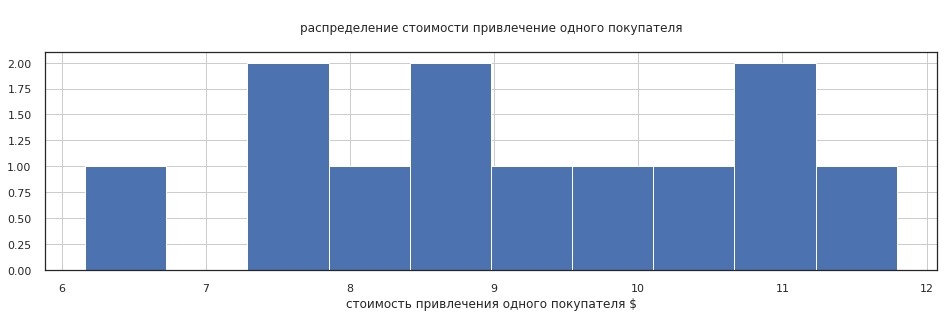


Средняя стоимость привлечения одно покупателя: 9.01 $



In [76]:
# посмотрим на распределение этой стоимости

user_cost.cac.hist(figsize = (16,4))
plt.title("\n" + 'распределение стоимости привлечение одного покупателя' + "\n")
plt.xlabel('стоимость привлечения одного покупателя $')
plt.show()

print("\n" + 'Средняя стоимость привлечения одно покупателя:', round(costs.costs.sum() / orders.uid.nunique(), 2), '$' + "\n")

Самых дорогих покупателей привлекли с канала №3. При этом они принесли почти столько же выручки, сколько каналы 4 и 5, в которых стоимость одного покупателя ниже в два раза.

Канал № 2 второй по стоимости платящего пользователя. Покупатели в нем стоят дорого, а выручки приносят немного.

**Далее посмотрим, как менялась стоимость привлечения в каждом канале по месяцам.**

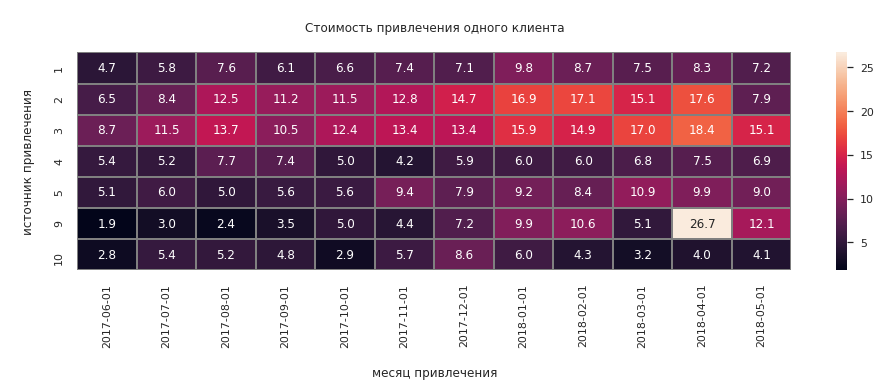

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
Средний CAC,5.02,6.50,7.73,7.03,7.02,8.19,9.26,10.53,10.00,9.37,13.20,8.89


In [77]:
# сделаем сводную таблицу из таблицы с расходами по источникам за каждый месяц
source_cac_by_month = buyers_by_source_month.pivot_table(index = 'source_id',
                                                         columns = 'month',
                                                         values = 'cac',
                                                         aggfunc = 'mean')

# визуализируем
plt.figure(figsize=(16, 4))
sns.heatmap(source_cac_by_month, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Стоимость привлечения одного клиента' + "\n")
plt.ylabel("\n" + 'источник привлечения' + "\n")
plt.xlabel("\n" + 'месяц привлечения')
plt.show()

pd.DataFrame(source_cac_by_month.mean().to_frame(name = 'Средний CAC')).T

Стоимость привлечения в каждом канале растет к январю, а потом немного идет на спад. <br>
По 2 и 3 каналу видно, что высокая средняя стоимость привлечения в этих каналах обусловлена высокой стоимостью в период с января по апрель 2018 года.

#### На сколько окупились расходы? (ROMI)

In [78]:
print("\n" + 'Итоговый ROMI:', round(orders.revenue.sum() / costs.costs.sum(), 2))


Итоговый ROMI: 0.77


В целом рекламная кампания не окупилась.

Посмотрим на окупаемость источников.

In [79]:
# сгруппируем таблицу с информацией о заказах по источнику
total_romi_by_source = orders.groupby('source_id').agg({'revenue': 'sum'})

# добавим к таблице информацию о расходах
total_romi_by_source = total_romi_by_source.join(cohort_costs_by_source)

# посчитаем окупаемость каждого источника
total_romi_by_source['romi'] = total_romi_by_source['revenue'] / total_romi_by_source['costs']
total_romi_by_source

,revenue,costs,romi
source_id,,,
1,31090.55,20833.27,1.49
2,46923.61,42806.04,1.10
3,54511.24,141321.63,0.39
4,56696.83,61073.60,0.93
5,52624.02,51757.10,1.02
7,1.22,nan,nan
9,5759.40,5517.49,1.04
10,4450.33,5822.49,0.76


Расходы на привлечения окупились не во всех каналах. <br>

Окупились только 1, 2, 9 и 5 каналы. <br>
Больше всех прибыли принес канал 1. Остальные окупились почти в ноль. <br>

Все остальные каналы не окупились. <br>
Канал № 3, в который влили больше всего бюджета, вернул меньше половины этого бюджета.

Дале посмотрим на окупаемость когорт.

In [80]:
# у нас уже есть таблица, где посчитан размер когорты и ltv на каждый месяц её возраста
ltv_by_user.head()

,acquisition_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2923,2017-06-01,9557.49,0,3.27
1,2017-06-01,2923,2017-07-01,2664.58,1,0.91
2,2017-06-01,2923,2017-08-01,1464.69,2,0.50
3,2017-06-01,2923,2017-09-01,3882.09,3,1.33
4,2017-06-01,2923,2017-10-01,3940.59,4,1.35


In [81]:
# добавим к этой таблице данные о средней стоимости привлечения клиента за каждый месяц
report_new = ltv_by_user.merge(user_cost[['month', 'cac']], left_on='acquisition_month', right_on='month')
report_new = report_new.drop(columns=['month'])

# посчитаем среднюю окупаемость одного клиента в когорте
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new.head() 

,acquisition_month,n_buyers,order_month,revenue,age,ltv,cac,romi
0,2017-06-01,2923,2017-06-01,9557.49,0,3.27,6.16,0.53
1,2017-06-01,2923,2017-07-01,2664.58,1,0.91,6.16,0.15
2,2017-06-01,2923,2017-08-01,1464.69,2,0.50,6.16,0.08
3,2017-06-01,2923,2017-09-01,3882.09,3,1.33,6.16,0.22
4,2017-06-01,2923,2017-10-01,3940.59,4,1.35,6.16,0.22


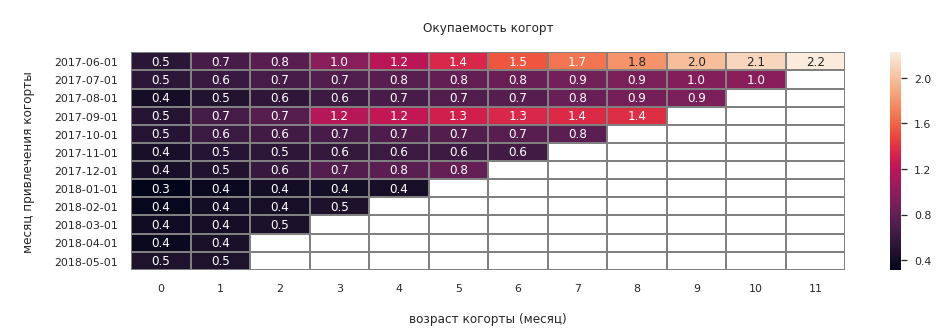

age,0,1,2,3,4,5,6,7,8,9,10,11
Средняя окупаемость,0.44,0.51,0.58,0.71,0.80,0.91,0.98,1.10,1.25,1.28,1.55,2.22


In [82]:
# сделаем сводную таблицу, в которой для каждой когорты отобразим накопленную окупаемость на каждый месяц жизни
romi_pivot = report_new.pivot_table(
        index='acquisition_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1)


# визуализируем
plt.figure(figsize=(16, 4))
sns.heatmap(romi_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Окупаемость когорт' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)')
plt.show()

pd.DataFrame(romi_pivot.mean().to_frame(name = 'Средняя окупаемость')).T

Окупились только три когорты: июньская, июльская и сентябрьская. <br>
При этом июльская и сентябрьская когорты окупились уже 4 месяц жизни, а июньская только на 10 месяц.

В среднем когорта окупается на 8 месяц жизни.

### Выводы о показателях маркетинга
[К оглавлению](#оглавление)<br>

В среднем привлечение одного покупателия стоило 9$. <br>
Стоимость разная у разных источников.<br>
В канале №3 покупатели стоят дороже, чем во всех других каналах. На этот канал потратили больше всего бюджета.
При этом он не приносит значительно больше выручки, чем два других канала, где стоимость привлечения в 2 раза ниже.

Из всех источников окупились только 1, 2, 9 и 5 каналы. Каналы 9 и 5 принесли не много прибыли: 2% и 4% сверх вложений соответственно.

Большую часть бюджета в следующей рекламной кампании стоит разделить между перечислеными каналами.

Стоит подумать над 4 каналом, так как он принес больше всего выручки при низкой стоимости привлечения. За год канал не окупился, но был близок к этому. Нужно детально посмотреть на темпы роста окупаемости.

***

## Шаг 3. Основные выводы и рекомендации <a id="Шаг_3"></a>
[К оглавлению](#оглавление)<br>
+ Куда и сколько стоит вкладывать денег? 

Определим, от каких источников стоит отказаться, а затем попробуем ранжировать их по стоимости привлечения. Стоит вкладывать большую часть средств туда, где стоимость привлечения самая низкая, пользователи много платят, а расходы окупаются.

### Сравним ключевые метрики привлечения пользователей в разрезе разных каналов трафика

Чтобы сравнить ключевые метрики в разрезе устройств и источников трафика, создадим простые когорты по устройству и источнику первого посещения без учета месяца привлечения. <br>

Нас в первую очередь интересуют характерные значения в разных устройствах и источника, а не подробная информация по каждому из них. Поэтому создавать когорты по месяцу привлечения и устройству/источнику будет излишним.

#### Как LTV различается на разных  устройствах?

Посмотрим на средний LTV в разрезе разных устройств. <br>
Немного упростим задачу и создадим когорты только по типу первого устройства, а не по месяцу привлечения и устройству. <br> Нас интересуют именно различия между устройствами, а не поведение когорт каждого устройства за каждый месяц.

In [83]:
# сгруппируем всех уникальных пользователей по устройству
buyers_cohorts_by_device = (orders.groupby('device')
                  .agg({'uid': 'nunique'})
                  .rename(columns = {'uid': 'cohort_size'}))
buyers_cohorts_by_device

,cohort_size
device,
desktop,29211
touch,7312


In [84]:
# сгруппируем таблицу заказов по типу устройства и возрасту и на каждый возраст найдем общую выручку
ltv_by_device = (orders
                 .groupby(['device', 'cohort_age'])
                          .agg({'revenue': 'sum'})
                )
ltv_by_device.head()

revenue
device  cohort_age           
desktop 0           117165.49
        1            18442.39
        2            13011.79
        3            23398.22
        4             9767.11

In [85]:
# построим сводную таблицу с общей накопленной выручкой за каждый возраст для каждого девайса
ltv_by_device = ltv_by_device.pivot_table(index = 'device',
                                          columns = 'cohort_age',
                                          values = 'revenue',
                                          aggfunc = 'sum'
                                         ).cumsum(axis = 1)
ltv_by_device

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,117165.49,135607.88,148619.67,172017.89,181785.00,190170.28,196119.52,200374.65,203704.70,207245.48,209631.67,211329.77
touch,25142.97,30100.99,32245.66,33855.92,35112.16,36304.34,37164.05,38343.54,39305.13,40212.74,40497.72,40727.43


In [86]:
# добавим к таблице размер каждой когорты из таблицы, которую создавали ранее
ltv_by_device = buyers_cohorts_by_device[['cohort_size']].join(ltv_by_device)
ltv_by_device

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,,
desktop,29211,117165.49,135607.88,148619.67,172017.89,181785.00,190170.28,196119.52,200374.65,203704.70,207245.48,209631.67,211329.77
touch,7312,25142.97,30100.99,32245.66,33855.92,35112.16,36304.34,37164.05,38343.54,39305.13,40212.74,40497.72,40727.43


In [87]:
# найдем лтв на каждый месяц: разделим накопленную выручку в каждом месяце на размер когорты
ltv_by_device = (ltv_by_device
                 .div(ltv_by_device['cohort_size'], axis = 0)
                 .drop(columns = 'cohort_size') # и избавимся от столбца с размером когорты, чтобы он не мешал визуализации
                )
ltv_by_device

,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,4.01,4.64,5.09,5.89,6.22,6.51,6.71,6.86,6.97,7.09,7.18,7.23
touch,3.44,4.12,4.41,4.63,4.80,4.97,5.08,5.24,5.38,5.50,5.54,5.57


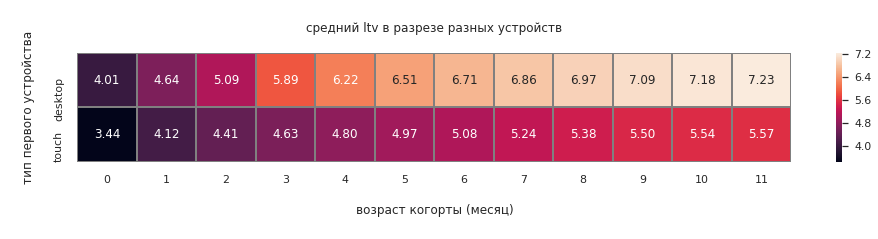

In [88]:
# визуализируем таблицу

plt.figure(figsize=(16, 2))

sns.heatmap(ltv_by_device, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

plt.title("\n" + 'средний ltv в разрезе разных устройств' + "\n")
plt.ylabel("\n" + 'тип первого устройства' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

Средний ltv на момент привлечения различаеется не значительно. <br>
Но уже на 12 месяц жизни средний клиент из когорты десктопа приносит на 1,66 доллар больше. <br>
Средний ltv клиента с десктопа растет быстрее. Следовательно, основную часть бюджета стоит тратить на десктоп, а не на мобильную рекламу (как это и делают сейчас).

#### Как LTV различается у пользователей из разных источников трафика?

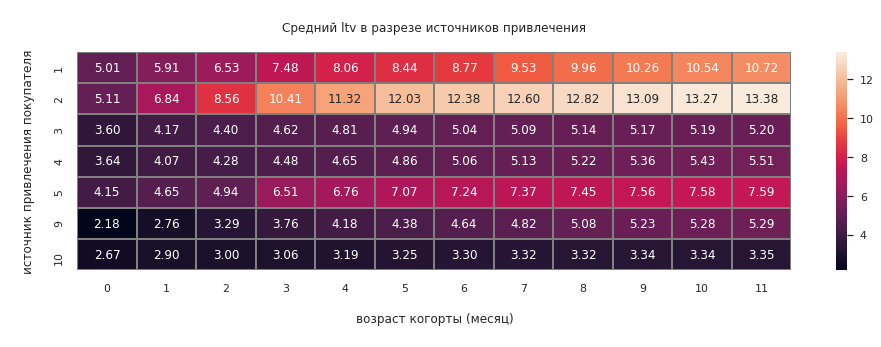

In [89]:
# сгруппируем таблицу с заказами по источникам и возрасту когорты и найдем выручку на каждый месяц возраста
ltv_by_source = (orders
                 .groupby(['source_id', 'cohort_age'])
                          .agg({'revenue': 'sum'})
                )

# в сводной таблице отобразим выручку с каждого источника на каждый месяц жизни когорты
ltv_by_source = ltv_by_source.pivot_table(index = 'source_id',
                                          columns = 'cohort_age',
                                          values = 'revenue',
                                          aggfunc = 'sum'
                                         ).cumsum(axis = 1)

# добавим к сводной таблице информацию о размере когорт
ltv_by_source = buyers_cohorts_by_source[['cohort_size']].join(ltv_by_source)

# размер выручки за каждый месяц возраста разделим на размер когорты, чтобы найти ltv одного клиента
ltv_by_source = (ltv_by_source
                 .div(ltv_by_source['cohort_size'], axis = 0)
                 .drop(columns = 'cohort_size')
                 .drop(index = 7) #дропнем седьмой источник, так как на него не было расходов
                )
# визуализируем
plt.figure(figsize=(16, 4))
sns.heatmap(ltv_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Cредний ltv в разрезе источников привлечения' + "\n")
plt.ylabel("\n" + 'источник привлечения покупателя' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

У пользователей из 1 и 2 каналов lTV растет быстрее всех: через год средняя выручка с одного клиента в этих когортах составляет больше 200% от средней выручки первого месяца.

Также можно выделить пятый и девятые каналы. Выручка в них растет медленее, чем у каналов 1 и 2,но быстрее чем у остальных.

#### На сколько окупились расходы на каждый источник трафика?

In [90]:
# таблица, из которой считаем окупаемость одного покупателя
# изначально в ней был накопительный ltv по каждому источнику за каждый месяц
# потом добавили инфу о средней стоимости привлечения в каждом источнике

romi_by_source = ltv_by_source.merge(buyers_cohorts_by_source['cac'], on = 'source_id', how = 'left')
romi_by_source

,0,1,2,3,4,5,6,7,8,9,10,11,cac
source_id,,,,,,,,,,,,,
1,5.01,5.91,6.53,7.48,8.06,8.44,8.77,9.53,9.96,10.26,10.54,10.72,7.19
2,5.11,6.84,8.56,10.41,11.32,12.03,12.38,12.60,12.82,13.09,13.27,13.38,12.21
3,3.60,4.17,4.40,4.62,4.81,4.94,5.04,5.09,5.14,5.17,5.19,5.20,13.49
4,3.64,4.07,4.28,4.48,4.65,4.86,5.06,5.13,5.22,5.36,5.43,5.51,5.93
5,4.15,4.65,4.94,6.51,6.76,7.07,7.24,7.37,7.45,7.56,7.58,7.59,7.47
9,2.18,2.76,3.29,3.76,4.18,4.38,4.64,4.82,5.08,5.23,5.28,5.29,5.07
10,2.67,2.90,3.00,3.06,3.19,3.25,3.30,3.32,3.32,3.34,3.34,3.35,4.38


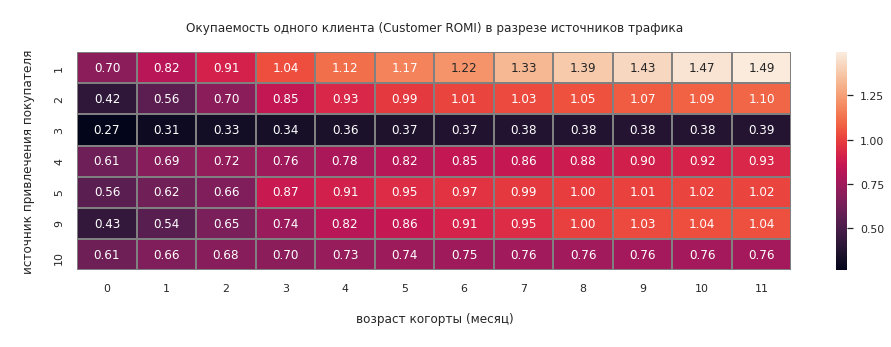

In [91]:
# найдем окупаемость одного клиента в когортах
romi_by_source = (romi_by_source
                 .div(romi_by_source['cac'], axis = 0)
                 .drop(columns = 'cac')
                )

# визуализируем
plt.figure(figsize=(16, 4))
sns.heatmap(romi_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Окупаемость одного клиента (Customer ROMI) в разрезе источников трафика' + "\n")
plt.ylabel("\n" + 'источник привлечения покупателя' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

Как мы уже видели, окупились только четыре канала: 1,2, 5 и 9. <br>
На этом графике видна скорость окупаемости. <br>

Быстрее и лучше окупается 1 канал. Он окупается уже на 4 месяц жизни, а еще через 8 приносит почти 50% сверху от стоимости привлечения <br>

Второй канал окупается медленее — на 7 месяц.

5 и 9 каналы окупаются медленее: затраты отбиваются только через 9 месяцев.

Темпы накопления выручки в 4 канале очень медленные. От него все же следует отказаться.

#### Как различается удержания у пользователей, привлеченных из разных каналов

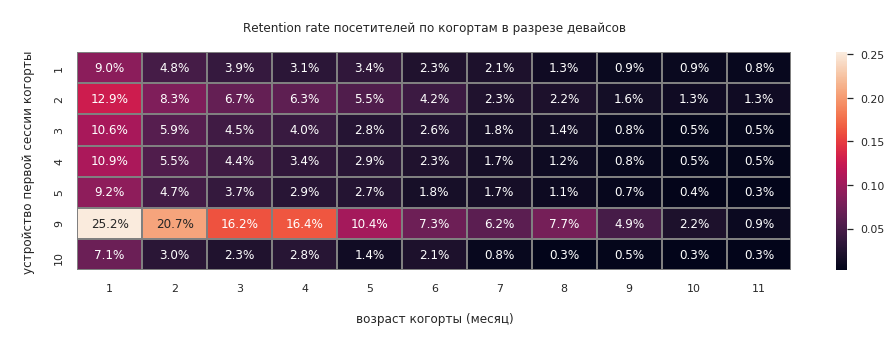

In [92]:
# сгруппируем таблицу с заказами по источнику и возрасту клиента
# на каждый месяц возраста найдем кол-во уникальных пользователей

source_buyers_cohorts = orders.groupby(['source_id','cohort_age']).agg({'uid':'nunique'}).reset_index()

# посчитаем размер когорты на нулевой месяц
source_buyers_cohorts_size = source_buyers_cohorts[source_buyers_cohorts['cohort_age'] == 0][['source_id','uid']]
source_buyers_cohorts_size = source_buyers_cohorts_size.rename(columns={'uid':'cohort_users'})

# к таблице с когортам добавим информацию о размере когорты в месяц привлечения
source_buyers_cohorts = source_buyers_cohorts.merge(source_buyers_cohorts_size,on='source_id')

# посчитаем retention как отношение кол-ва пользователей в каждый следующий месяц к количеству пользователей в первый месяц
source_buyers_cohorts['retention'] = source_buyers_cohorts['uid'] / source_buyers_cohorts['cohort_users'] 
source_buyers_cohorts.head()

# сделаем сводную таблицу:
# для каждой когорты на каждый месяц жизни отобразим долю вернувшихся пользователей от их изначального кол-ва

source_retention_pivot = (source_buyers_cohorts
                   .pivot_table(index='source_id',
                                      columns='cohort_age',
                                      values='retention',
                                      aggfunc='sum')
                    .drop(index = 7)
                  )

# удалим нулевой возраст, потому что в нем удержание будет 100%
source_retention_pivot = source_retention_pivot.drop(columns = 0)

# визуализируем таблицу
sns.set(style='white')
plt.figure(figsize=(16, 4))
sns.heatmap(source_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

plt.title("\n" + 'Retention rate посетителей по когортам в разрезе девайсов' + "\n")
plt.ylabel("\n" + 'устройство первой сессии когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

Лучшее удержание у канала 9: четверть всех покупателей возвращается во второй месяц за новой покупкой и еще 1/5 в третий. <br>
На 9 месяц жизни в этой когорте лучший retention: он в 5-6 раз больше, чем у пользователей с других каналов.

Retention rate первого месяца у 2 канала тоже лучше, чем у других каналов. <br>
Как  и в 9 канале, он снижается медленно и к 9 месяцу в два раза больше, чем у остальных каналов.

***

**Соберем все таблицы в одном месте, чтобы было легче принять решение.**

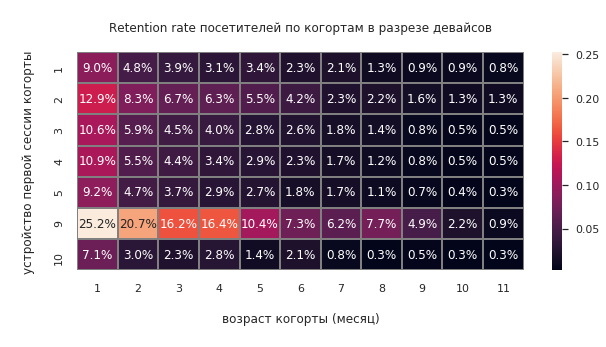

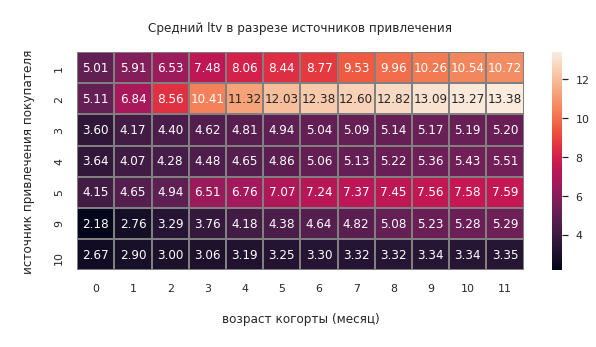

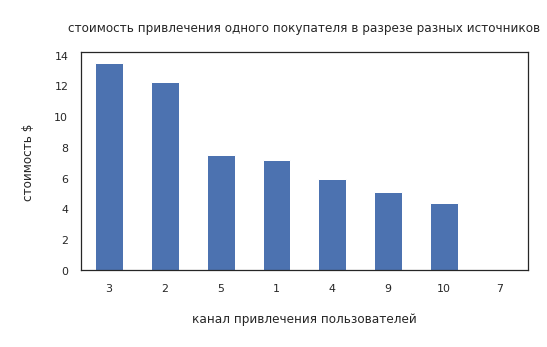

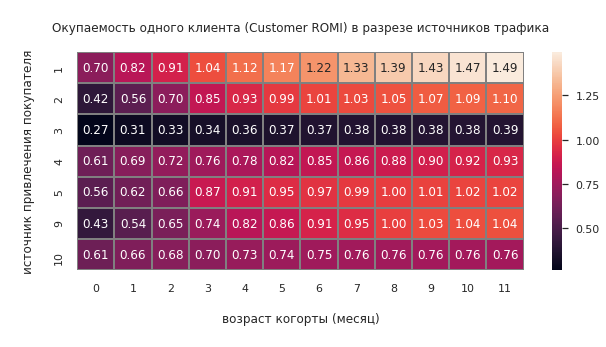

In [93]:
# визуализируем retention по каналам
sns.set(style='white')
plt.figure(figsize=(10, 4))
sns.heatmap(source_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

plt.title("\n" + 'Retention rate посетителей по когортам в разрезе девайсов' + "\n")
plt.ylabel("\n" + 'устройство первой сессии когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()


# визуализируем ltv в разрезе разных каналов
plt.figure(figsize=(10, 4))

sns.heatmap(ltv_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Cредний ltv в разрезе источников привлечения' + "\n")
plt.ylabel("\n" + 'источник привлечения покупателя' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()



# визуализируем стоимость привлечения по каналам
(buyers_cohorts_by_source['cac']
             .sort_values(ascending = False)
             .plot(kind = 'bar', figsize = (8,4), rot = 0)
)

plt.title("\n" + 'стоимость привлечения одного покупателя в разрезе разных источников' + "\n")
plt.ylabel("\n" + 'стоимость $' + "\n")
plt.xlabel("\n" + 'канал привлечения пользователей' + "\n")
plt.show()


# визуализируем окупаемость разных каналов
plt.figure(figsize=(10, 4))

sns.heatmap(romi_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Окупаемость одного клиента (Customer ROMI) в разрезе источников трафика' + "\n")
plt.ylabel("\n" + 'источник привлечения покупателя' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

### Выводы и рекомендации <a id="Шаг_3"></a>
[К оглавлению](#оглавление)<br>

Маркетологам следует отказаться от следующих каналов: 3, 4, и 10. Эти каналы убыточные, так как за целый год выручка со среднего клиента в них не отбивает затраты на привлечение.

Примерно 75-80% всего бюджета стоит выделить на десктопные рекламные кампании: средний ltv с одного клиента на этом устройстве накапливается быстрее, покупку совершают быстрее, а средний чек немного выше, чем на тач устройствах.

По источникам бюджет следует разделить следующим образом. <br>

50% бюджета — 1 каналу. Пользователи из этого канала окупаются уже через 4 месяца и к 12 месяцу приносят прибыль в размере 50% от стоимости привлечения. Выручка с клиента к концу года увеличивается в два раза. Стоимость клиента в этом канале не высокая — около 7$.

30% бюджета — 2 каналу. Пользователь из этого канала окупается через 10 месяцев и приносит немного прибыли. Однако стоимость привлечения здесь почти в 2 раза выше, чем в 1 канале — около 12$.

20% бюджета — разделить между 5 и 9 каналами. Эти каналы окупаются медленно и практически в ноль. <br>
Они приносят хорошую выручку, стоимость привлечения в них небольшая, но с них трудно получить прибыль 

Учитывая, что основную прибыль сервис скорее всего получает от партнерства, отсутствие прибыли из этих каналов не критичино. <br> Важно, чтобы они приводили новых пользователей, так как, как мы выяснили, бизнес напрямую зависит от их количества.